<a href="https://colab.research.google.com/github/williammorton235/Final-Project/blob/master/Project_code_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import os
import time
import datetime as dt
import pandas as pd
import numpy as np
import itertools
from math import sqrt

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from scipy.stats import wilcoxon
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import colors
import datetime as dt
from dateutil.relativedelta import *
from sklearn.metrics import confusion_matrix
pyplot.rcParams['figure.figsize'] = (10, 5)

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import linear_model
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

scaler = StandardScaler()

Get Data

In [ ]:
data = pd.read_csv('Data_EuroDollar_Avg.csv', header=0)
data = data.dropna()
data['Date'] = pd.to_datetime(data['Date'], format="%b-%y")
print(data)


          Date  EXUSEU_Avg   US_GDP  US_IR      US_CPI       US_M3   US_BOP  \
1   2001-01-01      0.9376  92.2054   5.15   73.876600  100.000000 -35202.0   
3   2001-02-01      0.9205  91.5813   4.88   74.171900  101.000000 -29301.0   
5   2001-03-01      0.9083  91.3567   4.42   74.340700  102.000000 -32812.0   
7   2001-04-01      0.8925  91.0720   3.87   74.636000  103.000000 -30521.0   
9   2001-05-01      0.8753  90.5335   3.62   74.973500  103.000000 -27095.0   
..         ...         ...      ...    ...         ...         ...      ...   
473 2020-09-01      1.1785  95.6019   0.11  109.814908  373.909723 -62625.0   
475 2020-10-01      1.1768  96.6454   0.10  109.860474  376.845934 -63678.0   
477 2020-11-01      1.1826  97.1609   0.09  109.793390  381.048274 -67307.0   
479 2020-12-01      1.2168  98.2854   0.09  109.896759  384.488926 -65802.0   
481 2021-01-01      1.2178  99.3244   0.08  110.364236  389.802645 -67092.0   

         US_DM3     US_UC      EU_GDP  EU_IR  EU_CP

Experiment Selector

In [ ]:
def selectExperiment(data, experiment):
    if experiment == 1:
        data = data
    elif experiment == 2.1:  # simple sum
        data = data.drop(list(data.filter(regex='^EX'))+list(data.filter(regex='GDP$'))+list(data.filter(regex='UC$'))+list(data.filter(regex='CPI$'))+list(data.filter(regex='BOP$'))+list(data.filter(regex='_DM3$'))+list(data.filter(regex='^OIL')), axis=1)
    elif experiment == 2.2:  # divisia
        data = data.drop(list(data.filter(regex='^EX'))+list(data.filter(regex='GDP$'))+list(data.filter(regex='IR$'))+list(data.filter(regex='CPI$'))+list(data.filter(regex='_M3$'))+list(data.filter(regex='BOP$'))+list(data.filter(regex='^OIL')), axis=1)
    elif experiment == 3.1:  # simple sum
        data = data.drop(list(data.filter(regex='^EX'))+list(data.filter(regex='_DM3$'))+list(data.filter(regex='UC$')), axis=1)
    elif experiment == 3.2:  # divisia
        data = data.drop(list(data.filter(regex='^EX'))+list(data.filter(regex='_M3$'))+list(data.filter(regex='IR$')),axis=1)
    return data

Create dataset

In [ ]:
def make_set(horizon, experiment, filename):
    data = pd.read_csv(filename, header=0)
    data = data.dropna()
    data['Date'] = pd.to_datetime(data['Date'], format="%b-%y")
    data = data.copy()
    y = data.filter(regex='^EX').values
    y = y.flatten()
    y = np.sign([1.0 if y[i + horizon] - y[i] == 0.0 else y[i + horizon] - y[i] for i in range(len(y) - horizon)])
    y = np.concatenate((y, [np.nan] * (len(data.filter(regex='^EX')) - len(y))))
    data['Direction'] = y
    data.dropna(inplace=True)
    data.reset_index(drop=True,inplace=True)
    data = selectExperiment(data, experiment)
    return data

Make lagged or differenced features

In [ ]:
def createRollingWindow(data, window):  # real valued data
  df = data.copy()
  df = df.drop(['Date', 'Direction'], axis=1)
  columns = list(df.columns)*window
  df = df.values
  windowed_data = np.array([df[j - window:j, :].flatten() for j in range(window, len(df))])
  df = pd.DataFrame(windowed_data, columns=columns)
  df['Date'] = data['Date']
  df['Direction'] = data['Direction'][window:].reset_index(drop=True)
  return df.reset_index(drop=True)


def createRollingWindowdiff(data, window):  # differenced data
  df = data.copy()
  df = df.drop(['Date', 'Direction'], axis=1)
  columns = list(df.columns)*window
  for difference in range(1, window+1, 1):
    for column in columns:
      df[column+str(difference)] = df[column].diff(difference)
  df = df.drop(columns, axis=1)
  df['Date'] = data['Date']
  df['Direction'] = data['Direction'][window:].reset_index(drop=True)
  return df.dropna().reset_index(drop=True)


Time Series Analysis on Euro/Dollar

Mean: -0.0010894908847988564
Median: -0.0010465429700689186
Min: -0.061934322991335194
Max: 0.07798792435701879
Std: 0.02203704793442774
Skew: 0.16806041863237903
Kurtosis: 0.8209177984129399
ShapiroResult(statistic=0.9906856417655945, pvalue=0.12838035821914673)


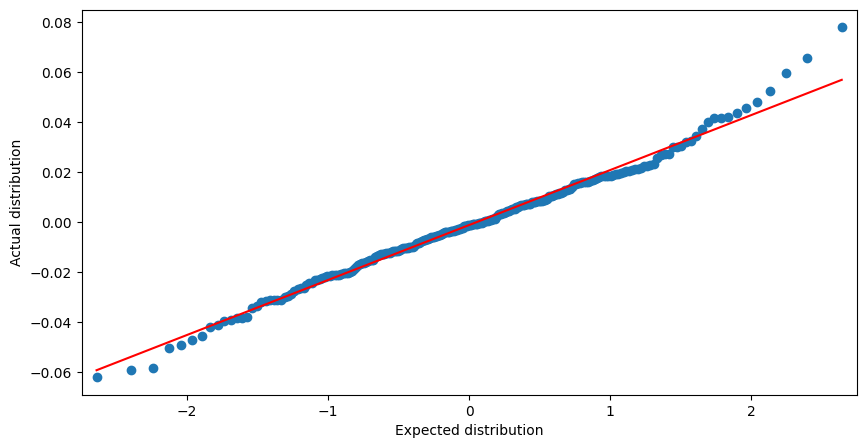

In [ ]:
data = pd.read_csv('Data_EuroDollar_Avg.csv', header=0)
data['Date'] = pd.to_datetime(data['Date'], format="%b-%y")
dataset = data.dropna()

log_returns = np.log(dataset['EXUSEU_Avg']) - np.log(dataset['EXUSEU_Avg'].shift(-1))
log_returns = log_returns.dropna()
print("Mean:", log_returns.mean())
print("Median:", log_returns.median())
print("Min:", log_returns.min())
print("Max:", log_returns.max())
print("Std:", log_returns.std())
print("Skew:", log_returns.skew())
print("Kurtosis:", log_returns.kurtosis())
print(shapiro(log_returns))

fig, ax = plt.subplots(figsize=(10, 5))
qqplot(log_returns, line='s', ax=ax)
plt.xlabel('Expected distribution')
plt.ylabel('Actual distribution')
plt.show()

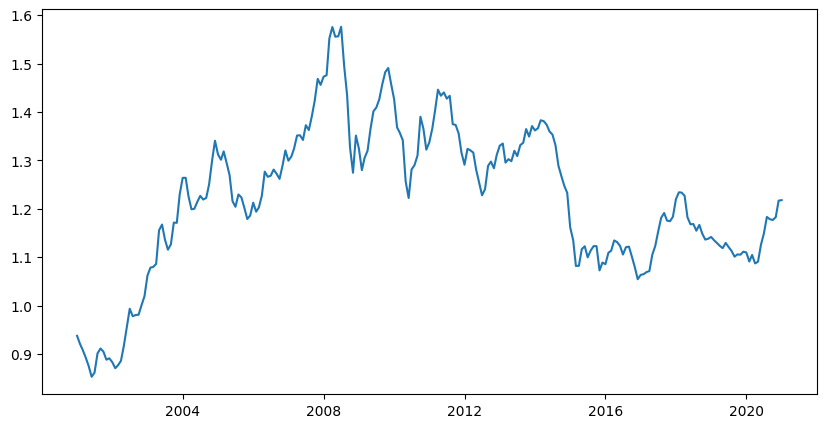

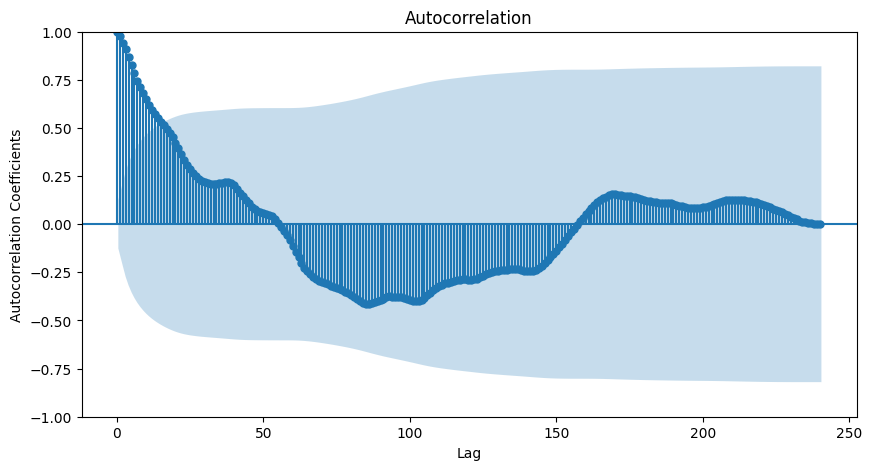

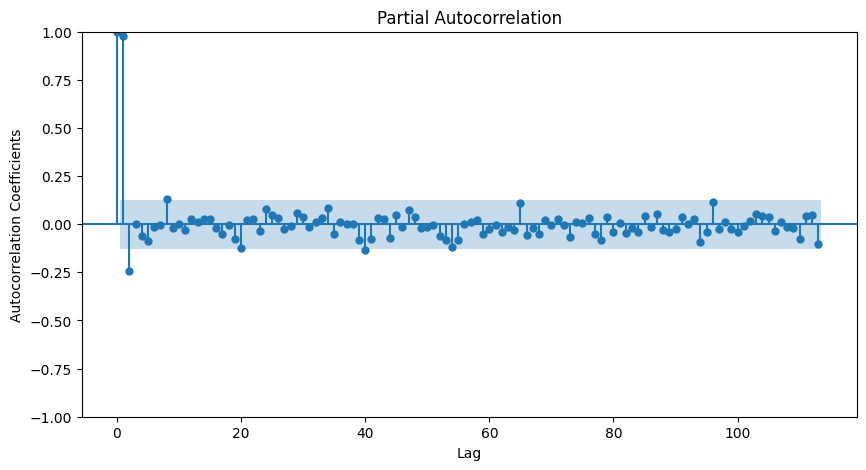

In [ ]:
plt.plot(dataset['Date'], dataset['EXUSEU_Avg'])
plt.show()
plot_acf(dataset['EXUSEU_Avg'], lags = len(dataset['EXUSEU_Avg'])-1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficients')
plt.show()
plot_pacf(dataset['EXUSEU_Avg'], lags = 113)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficients')
plt.show()

1.1077797224147873e-20


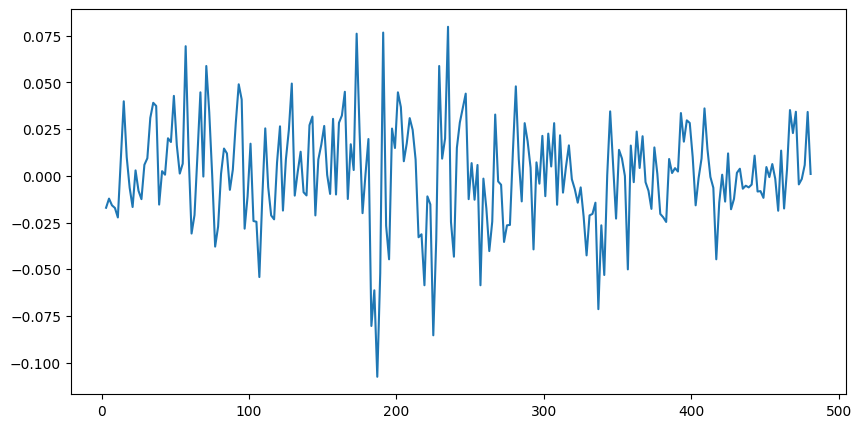

In [ ]:
series = dataset['EXUSEU_Avg']
series = series.diff().dropna()
result = adfuller(series)
print(result[1])
plt.plot(series)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             EXUSEU_Avg   No. Observations:                  241
Model:                ARIMA(2, 1, 16)   Log Likelihood                 540.671
Date:                Sun, 07 Apr 2024   AIC                          -1043.342
Time:                        17:56:59   BIC                           -977.210
Sample:                             0   HQIC                         -1016.696
                                - 241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3593      0.814      0.441      0.659      -1.236       1.954
ar.L2          0.1422      0.811      0.175      0.861      -1.447       1.731
ma.L1         -0.0539      0.797     -0.068      0.9

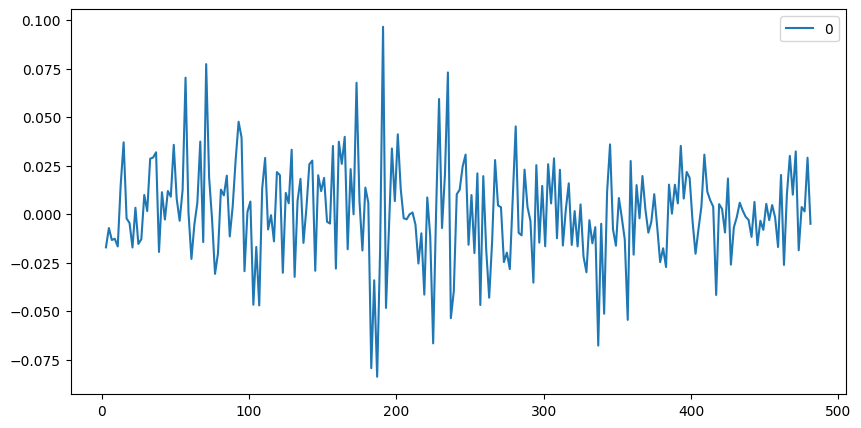

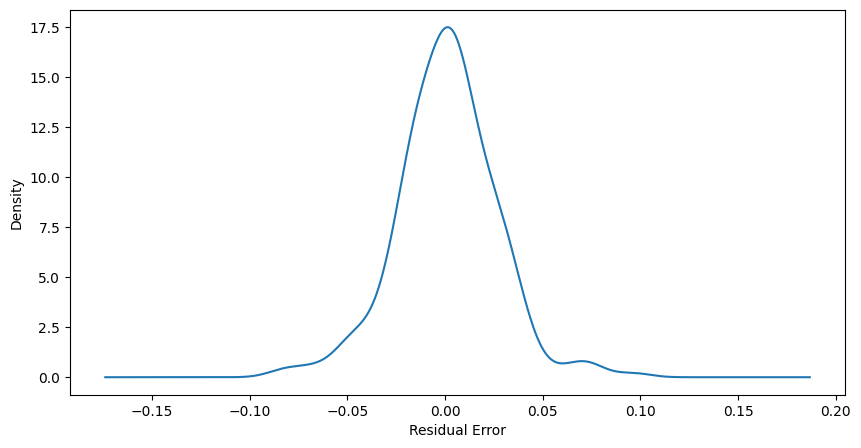

                0
count  240.000000
mean     0.000984
std      0.025440
min     -0.083755
25%     -0.014712
50%      0.001489
75%      0.015110
max      0.096522


In [ ]:
# load dataset
series = dataset['EXUSEU_Avg']
# fit model
model = ARIMA(series, order=(2,1,16))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid[1:])
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde', legend=None)
plt.xlabel('Residual Error')
plt.show()
# summary stats of residuals
print(residuals.describe())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.109010, expected=1.167400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.153418, expected=1.136500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.125556, expected=1.115500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.113981, expected=1.126700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.129561, expected=1.171400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.227980, expected=1.171000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.220365, expected=1.229800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.180242, expected=1.263800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.193222, expected=1.264000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.137286, expected=1.226100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.195210, expected=1.198900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.187060, expected=1.200000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.248740, expected=1.214600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.296048, expected=1.226600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.262606, expected=1.219100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.250752, expected=1.222400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.239642, expected=1.250700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.240256, expected=1.299700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.261702, expected=1.340600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.252523, expected=1.312300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.224795, expected=1.301300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.233370, expected=1.318500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.249210, expected=1.294300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.248911, expected=1.269700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.303823, expected=1.215500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.293437, expected=1.204100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.309442, expected=1.229500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=1.385412, expected=1.223400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.316544, expected=1.202200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.320281, expected=1.178900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.269340, expected=1.186100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.243460, expected=1.212600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.271270, expected=1.194000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.257330, expected=1.202800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.168398, expected=1.227300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.154904, expected=1.276700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.136412, expected=1.266100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.115346, expected=1.268100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.081845, expected=1.281000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.138314, expected=1.272200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.182713, expected=1.261700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=1.294387, expected=1.288800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.220271, expected=1.320500
predicted=1.267487, expected=1.299300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.264713, expected=1.308000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.219094, expected=1.324600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.273325, expected=1.351300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.387890, expected=1.351800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.378694, expected=1.342100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.319020, expected=1.372600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.385423, expected=1.362600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.321249, expected=1.391000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.311464, expected=1.423300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.341324, expected=1.468300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.316584, expected=1.455900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.382475, expected=1.472800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.351989, expected=1.475900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.428110, expected=1.552000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.437244, expected=1.575400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.477817, expected=1.555400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.433561, expected=1.556200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.483717, expected=1.575900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.462971, expected=1.495500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.622344, expected=1.434200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.546403, expected=1.326600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.574327, expected=1.274400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.604759, expected=1.351100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.627006, expected=1.324400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.436959, expected=1.279700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.415794, expected=1.305000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.270126, expected=1.319900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.151113, expected=1.364600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.548406, expected=1.401400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.280704, expected=1.409200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.209511, expected=1.426600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.221521, expected=1.457500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.243854, expected=1.482100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.345398, expected=1.490800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.384949, expected=1.457900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.462549, expected=1.426600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.449879, expected=1.368000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.472895, expected=1.357000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.531620, expected=1.341700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.503862, expected=1.256300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.416748, expected=1.222300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.412568, expected=1.281100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.290908, expected=1.290300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.289278, expected=1.310300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.337073, expected=1.390100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.232000, expected=1.365400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.226487, expected=1.322100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.374984, expected=1.337100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.328691, expected=1.365600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.323526, expected=1.402000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.416880, expected=1.446000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.355180, expected=1.433500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.251891, expected=1.440300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.289071, expected=1.427500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.401129, expected=1.433300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.417895, expected=1.374700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.466455, expected=1.373200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.423285, expected=1.355800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.387020, expected=1.315500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.356669, expected=1.291000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.472788, expected=1.323800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.414252, expected=1.320800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.391219, expected=1.316000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.345175, expected=1.280600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.291768, expected=1.254100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.226567, expected=1.227800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.295027, expected=1.240600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.345107, expected=1.288500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.328069, expected=1.297400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.298801, expected=1.283700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.292387, expected=1.311900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.237203, expected=1.330400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.247637, expected=1.334700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.339992, expected=1.295300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.324236, expected=1.302500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.271203, expected=1.298300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.311351, expected=1.319700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.320705, expected=1.308800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.332113, expected=1.331400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.296452, expected=1.336400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.331863, expected=1.364600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.299193, expected=1.349100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.302169, expected=1.370800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.278431, expected=1.361800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.312449, expected=1.366500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.323454, expected=1.382800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.365101, expected=1.381000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.365120, expected=1.373900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.379409, expected=1.359500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.370796, expected=1.353300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.366506, expected=1.331500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.385180, expected=1.288900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.359336, expected=1.267700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.344701, expected=1.247300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.326449, expected=1.232900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.318529, expected=1.161500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.302151, expected=1.135000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.260191, expected=1.081900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.268906, expected=1.082200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.246523, expected=1.116700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.244446, expected=1.122600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.145099, expected=1.099700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.130327, expected=1.113600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.058263, expected=1.122900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.087430, expected=1.122800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.156796, expected=1.072700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.156009, expected=1.088900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.141257, expected=1.085500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.166917, expected=1.109200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.196470, expected=1.113400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.184767, expected=1.134600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.094244, expected=1.131200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.112927, expected=1.123200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.077410, expected=1.105500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.080342, expected=1.120700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.065413, expected=1.121800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.120899, expected=1.101400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.147299, expected=1.079200


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.140641, expected=1.054500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.144497, expected=1.063500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.156953, expected=1.065000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.147712, expected=1.069100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.097418, expected=1.071400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.065688, expected=1.105000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.025600, expected=1.123300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.035292, expected=1.153000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.041747, expected=1.181300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.064340, expected=1.191300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.086827, expected=1.175500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.133864, expected=1.174300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.153855, expected=1.183600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.181527, expected=1.219700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.216056, expected=1.234000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.207060, expected=1.233400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.170374, expected=1.227000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.155795, expected=1.182300


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.160525, expected=1.167900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.201120, expected=1.168500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.212313, expected=1.154700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.212327, expected=1.166700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.209869, expected=1.148800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.148583, expected=1.136400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.157707, expected=1.138000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.167220, expected=1.141800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.148577, expected=1.134900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.171510, expected=1.129600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.132927, expected=1.123400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.123087, expected=1.118700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.128470, expected=1.129500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.143809, expected=1.121100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.149131, expected=1.112900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.145210, expected=1.101100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.140199, expected=1.105800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.122872, expected=1.105100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.136229, expected=1.111400


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.116334, expected=1.109800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.113606, expected=1.091100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.100928, expected=1.104600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.109728, expected=1.087100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.108577, expected=1.090700


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.114804, expected=1.125900


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.114831, expected=1.148800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.090984, expected=1.183100


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.120324, expected=1.178500


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.087575, expected=1.176800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.099985, expected=1.182600


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.144155, expected=1.216800


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.159762, expected=1.217800
Test RMSE: 0.095


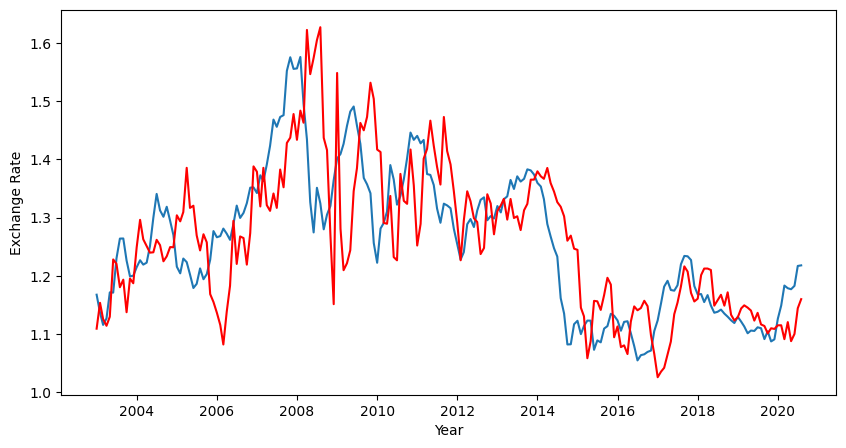

In [ ]:
# load dataset
series = dataset['EXUSEU_Avg']
dates = dataset['Date']
X = series.values
size = int(len(X) * 0.1)
dates = dates[size:len(X)]
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []
tested = []
# walk forward validation
for t in range(len(test)-5):
  model = ARIMA(history, order=(2,1,16))
  fitted = model.fit()
  output = fitted.forecast(steps=5)
  #print(output)
  predicted = output[4]
  predictions.append(predicted)
  tested.append(test[t+5])
  history.append(test[t])
  print('predicted=%f, expected=%f' % (predicted, test[t+5]))
# evaluate forecasts
rmse = sqrt(mean_squared_error(tested, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predictions and targets
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates[:-5], tested)
ax.plot(dates[:-5], predictions, color='red')
ax.set_ylabel('Exchange Rate')
ax.set_xlabel('Year')
plt.show()

Training and testing set creation

In [ ]:
def split_time_series(data, train_period, offset):
    start_date = dt.date(2002,1,1)
    trains = []
    tests = []
    start = start_date
    end = start
    while end < data['Date'].max().date():
        temp_trains = list(data[(data['Date'].dt.date >= start) & (data['Date'].dt.date < start+relativedelta(months=+train_period))].index)
        temp_tests = list(data[(data['Date'].dt.date >= start+relativedelta(months=+train_period+offset)) & (data['Date'].dt.date < start+relativedelta(months=+train_period+offset+1))].index)

        start = start+relativedelta(months=+1)
        end = start+relativedelta(months=+train_period+offset+1+1)

        trains.append(temp_trains)
        tests.append(temp_tests)

    train_test_split = [(train, test) for train, test in zip(trains, tests)]

    return train_test_split

In [ ]:
def forcasting(data, offset):
    dataset = data.copy()

    average_scores = []
    for window, train in itertools.product(range(1,7,1), [18,24,30]):
        eng_set = createRollingWindow(dataset, window)

        scores = []
        for trains, tests in split_time_series(eng_set.drop(['Direction'], axis=1), train_period=train, offset=offset):
            traind = eng_set.loc[trains]
            majority_val = int(traind.Direction.mode()[0])
            majority = traind[traind['Direction'] == majority_val]
            minority = traind[traind['Direction'] != majority_val]
            # Downsample majority class
            df_majority_downsampled = resample(majority, replace=False, n_samples=len(minority))
            downsample = pd.concat([df_majority_downsampled, minority])
            X_train = downsample.drop(['Direction', 'Date'], axis=1)
            y_train = downsample['Direction']
            X_test = eng_set.loc[tests].drop(['Direction', 'Date'], axis=1)
            y_test = eng_set.loc[tests]['Direction']

            pipeline = make_pipeline(scaler, model)
            try:
                pipeline.fit(X_train, y_train)
                scores.append(accuracy_score(y_test, pipeline.predict(X_test)))
            except:
                scores.append(accuracy_score(y_test, [majority_val]))

        print("Average score: {:.2f}%".format(np.mean(scores)*100))
        average_scores.append(np.mean(scores)*100)
        lag_df = pd.DataFrame(index=[18, 24, 30], columns=[1, 2, 3, 4, 5, 6])

    for (lag, train), i in zip(itertools.product([1, 2, 3, 4, 5, 6], [18, 24, 30]),range(len(average_scores))):
        lag_df.at[train, lag] = average_scores[i]
    lag_df = lag_df.astype(float)

    windows = []
    print(lag_df)
    for index, row in lag_df.iterrows():
        max_in_row = row.idxmax()
        windows.append(max_in_row)

    return windows

In [ ]:
def get_estimator(data, window, train, offset, model, param_grid):
    dataset = data.copy()

    pipeline = make_pipeline(scaler, model)
    print(pipeline)
    train_test_split = split_time_series(createRollingWindow(dataset,window), train_period=train, offset=offset)
    gridsearch = GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring='accuracy',cv=train_test_split, error_score=0)
    gridsearch.fit(createRollingWindow(dataset,window).drop(["Date", 'Direction'], axis=1), createRollingWindow(dataset,window)['Direction'])
    best_estimator = gridsearch.best_estimator_
    return best_estimator

In [ ]:
def test(data, train, window, estimator, offset):
    dataset = data.copy()
    best_estimator = estimator
    eng_set = createRollingWindow(dataset, window)

    scores = []
    predicted = []
    target = []
    n = 0
    _, s = createRollingWindow(dataset, window).iloc[:,2:].shape
    w = np.zeros(shape=(s,))

    for trains, tests in split_time_series(eng_set.drop(['Direction'], axis=1), train_period=train, offset=offset):

        traind = eng_set.loc[trains]
        majority_val = int(traind.Direction.mode()[0])
        majority = traind[traind['Direction'] == majority_val]
        minority = traind[traind['Direction'] != majority_val]
        # Downsample majority class
        df_majority_downsampled = resample(majority, replace=False, n_samples=len(minority))
        downsample = pd.concat([df_majority_downsampled, minority])
        X_train = downsample.drop(['Direction', 'Date'], axis=1)
        y_train = downsample['Direction']
        X_test = eng_set.loc[tests].drop(['Direction', 'Date'], axis=1)
        y_test = eng_set.loc[tests]['Direction']

        pipeline = make_pipeline(scaler, best_estimator[1])
        try:
            pipeline.fit(X_train, y_train)
            scores.append(accuracy_score(y_test, pipeline.predict(X_test)))
            predicted.append(float(pipeline.predict(X_test)[0]))
            target.append(y_test.item())
            try:
              w += list(map(abs, pipeline.named_steps['linearsvc'].coef_[0]))
            except:
              w += list(map(abs, pipeline.named_steps['logisticregression'].coef_[0]))
            n += 1
        except ValueError:
            scores.append(accuracy_score(y_test, [majority_val]))
            predicted.append(majority_val)
            target.append(y_test.item())

    print(classification_report(target, predicted))
    score = accuracy_score(target, predicted)

    w = w/n
    print("Average testing accuracy score: {:.2f}%".format(score*100))
    return score*100, target, predicted, w

In [ ]:
## run all sets
filenames = ["Data_EuroDollar_Avg.csv", "Data_MexDollarM3.csv", "Data_MexEuro.csv", "Data_SwissDollar_Avg.csv", "Data_SwissEuro_Avg.csv", "Data_YuanDollar.csv", "Data_YuanEuro.csv"]
models = [svm.LinearSVC(), linear_model.LogisticRegression()]
grids = [[{'linearsvc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}], [{'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]]
for filename in filenames:
    pair = filename.split("_")[1]
    for i in range(2):
        model = models[i]
        param_grid = grids[i]
        for experiment in [1, 2.1, 2.2, 3.1, 3.2]:
            print(experiment)
            graphing = pd.DataFrame(columns=['accuracy', 'forcasting', 'training'])
            all_target = []
            all_predicted = []
            all_importances = []
            all_names = []
            all_ws = []
            for horizon in [1, 3, 6, 12, 24, 36]:
                dataset = make_set(horizon, experiment, filename)
                windows = forcasting(dataset, 0)
                i = 0
                for train in [18, 24, 30]:
                    lags = int(windows[i])
                    estimator = get_estimator(dataset, lags, train, 0, model, param_grid)
                    score, target, predicted, w = test(dataset, train, lags, estimator, 0)
                    initial_feature_names = list(createRollingWindow(dataset,lags).iloc[:,:-2].columns)
                    importance_list = np.argsort(w)[::-1]
                    all_target.extend(target)
                    all_predicted.extend(predicted)
                    all_importances.extend(importance_list)
                    all_names.extend(initial_feature_names)
                    all_ws.extend(w.tolist())
                    all_ws.append('###')
                    i += 1
                    graphing.loc[len(graphing)] = [score, horizon, train]
            f = open('/content/drive/MyDrive/'+str(model)[:3]+str(experiment).replace('.','-')+pair+'.txt', 'w+')
            f.write(str(all_target)+'%'+str(all_predicted)+'%'+str(all_importances)+'%'+str(all_names)+'%'+str(all_ws))
            f.close()
            graphing.to_csv('/content/drive/MyDrive/'+str(model)[:3]+str(experiment).replace('.','-')+pair+'.csv')


1
Average score: 59.76%
Average score: 60.74%
Average score: 64.97%
Average score: 64.29%
Average score: 65.43%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 67.95%
Average score: 61.08%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 65.84%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 67.74%
Average score: 68.07%
Average score: 67.50%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 69.48%
Average score: 67.27%
Average score: 63.52%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 68.63%
Average score: 65.24%
Average score: 63.29%
Average score: 63.82%
            1          2          3          4          5          6
18  59.763314  64.285714  61.077844  68.072289  67.272727  65.243902
24  60.736196  65.432099  65.838509  67.500000  63.522013  63.291139
30  64.968153  67.948718  67.741935  69.480519  68.627451  63.815789
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
189 fits failed out of a total of 1494.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
189 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.77      0.70      0.73       113
         1.0       0.47      0.57      0.51        53

    accuracy                           0.66       166
   macro avg       0.62      0.63      0.62       166
weighted avg       0.68      0.66      0.66       166

Average testing accuracy score: 65.66%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.83      0.68      0.75       113
         1.0       0.46      0.66      0.54        47

    accuracy                           0.68       160
   macro avg       0.65      0.67      0.65       160
weighted avg       0.72      0.68      0.69       160

Average testing accuracy score: 67.50%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.82      0.70      0.75       109
         1.0       0.46      0.62      0.53        45

    accuracy                           0.68       154
   macro avg       0.64      0.66      0.64       154
weighted avg       0.71      0.68      0.69       154

Average testing accuracy score: 67.53%
Average score: 73.65%
Average score: 70.81%
Average score: 67.10%
Average score: 78.31%
Average score: 70.00%
Average score: 68.18%
Average score: 73.33%
Average score: 67.92%
Average score: 68.63%
Average score: 75.00%
Average score: 70.25%
Average score: 76.32%
Average score: 78.53%
Average score: 75.16%
Average score: 70.86%
Average score: 74.07%
Average score: 72.44%
Average score: 72.67%
            1          2          3          4          5          6
18  73.652695  78.313253  73.333333  75.000000  78.527607  74.074074
24  70.807453  70.000000  67.924528  70.253165  75.159236  72.435897
30  67.096774  68.181818  68.62

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
288 fits failed out of a total of 1467.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.85      0.74      0.79       114
         1.0       0.53      0.69      0.60        49

    accuracy                           0.72       163
   macro avg       0.69      0.72      0.70       163
weighted avg       0.75      0.72      0.73       163

Average testing accuracy score: 72.39%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.84      0.75      0.79       113
         1.0       0.50      0.64      0.56        44

    accuracy                           0.72       157
   macro avg       0.67      0.69      0.68       157
weighted avg       0.75      0.72      0.73       157

Average testing accuracy score: 71.97%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.84      0.77      0.80       108
         1.0       0.53      0.64      0.58        44

    accuracy                           0.73       152
   macro avg       0.68      0.70      0.69       152
weighted avg       0.75      0.73      0.74       152

Average testing accuracy score: 73.03%
Average score: 69.51%
Average score: 62.66%
Average score: 72.37%
Average score: 71.78%
Average score: 68.79%
Average score: 69.54%
Average score: 71.60%
Average score: 66.67%
Average score: 73.33%
Average score: 70.19%
Average score: 68.39%
Average score: 69.80%
Average score: 74.38%
Average score: 75.97%
Average score: 75.00%
Average score: 72.96%
Average score: 73.20%
Average score: 72.79%
            1          2          3          4          5          6
18  69.512195  71.779141  71.604938  70.186335  74.375000  72.955975
24  62.658228  68.789809  66.666667  68.387097  75.974026  73.202614
30  72.368421  69.536424  73.33

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
333 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.87      0.77      0.82       114
         1.0       0.56      0.72      0.63        46

    accuracy                           0.76       160
   macro avg       0.72      0.74      0.72       160
weighted avg       0.78      0.76      0.76       160

Average testing accuracy score: 75.62%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.92      0.71      0.80       110
         1.0       0.54      0.84      0.65        44

    accuracy                           0.75       154
   macro avg       0.73      0.78      0.73       154
weighted avg       0.81      0.75      0.76       154

Average testing accuracy score: 74.68%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.95      0.72      0.82       104
         1.0       0.58      0.91      0.71        44

    accuracy                           0.78       148
   macro avg       0.76      0.82      0.76       148
weighted avg       0.84      0.78      0.79       148

Average testing accuracy score: 77.70%
Average score: 84.81%
Average score: 83.55%
Average score: 82.19%
Average score: 81.53%
Average score: 83.44%
Average score: 82.76%
Average score: 86.54%
Average score: 83.33%
Average score: 79.17%
Average score: 85.81%
Average score: 83.89%
Average score: 84.62%
Average score: 85.71%
Average score: 86.49%
Average score: 83.10%
Average score: 86.93%
Average score: 85.03%
Average score: 80.85%
            1          2          3          4          5          6
18  84.810127  81.528662  86.538462  85.806452  85.714286  86.928105
24  83.552632  83.443709  83.333333  83.892617  86.486486  85.034014
30  82.191781  82.758621  79.16

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
828 fits failed out of a total of 1377.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
747 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.94      0.91      0.93       113
         1.0       0.77      0.85      0.81        40

    accuracy                           0.90       153
   macro avg       0.86      0.88      0.87       153
weighted avg       0.90      0.90      0.90       153

Average testing accuracy score: 89.54%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
666 fits failed out of a total of 1332.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
639 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train,

              precision    recall  f1-score   support

        -1.0       0.93      0.84      0.88       108
         1.0       0.66      0.82      0.73        40

    accuracy                           0.84       148
   macro avg       0.79      0.83      0.81       148
weighted avg       0.86      0.84      0.84       148

Average testing accuracy score: 83.78%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.93      0.82      0.87       103
         1.0       0.64      0.85      0.73        40

    accuracy                           0.83       143
   macro avg       0.79      0.83      0.80       143
weighted avg       0.85      0.83      0.83       143

Average testing accuracy score: 82.52%
Average score: 97.26%
Average score: 97.14%
Average score: 97.01%
Average score: 96.55%
Average score: 97.12%
Average score: 96.24%
Average score: 97.22%
Average score: 97.10%
Average score: 96.97%
Average score: 95.80%
Average score: 97.08%
Average score: 97.71%
Average score: 97.18%
Average score: 97.79%
Average score: 97.69%
Average score: 95.74%
Average score: 96.30%
Average score: 96.12%
            1          2          3          4          5          6
18  97.260274  96.551724  97.222222  95.804196  97.183099  95.744681
24  97.142857  97.122302  97.101449  97.080292  97.794118  96.296296
30  97.014925  96.240602  96.96

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1098 fits failed out of a total of 1314.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
936 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/lo

              precision    recall  f1-score   support

        -1.0       0.96      0.99      0.98       109
         1.0       0.97      0.89      0.93        37

    accuracy                           0.97       146
   macro avg       0.97      0.94      0.95       146
weighted avg       0.97      0.97      0.97       146

Average testing accuracy score: 96.58%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
954 fits failed out of a total of 1224.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
846 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.97      0.99      0.98        99
         1.0       0.97      0.92      0.94        37

    accuracy                           0.97       136
   macro avg       0.97      0.95      0.96       136
weighted avg       0.97      0.97      0.97       136

Average testing accuracy score: 97.06%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
855 fits failed out of a total of 1179.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
801 fits failed with the following error:
Traceback

              precision    recall  f1-score   support

        -1.0       0.97      0.99      0.98        94
         1.0       0.97      0.92      0.94        37

    accuracy                           0.97       131
   macro avg       0.97      0.95      0.96       131
weighted avg       0.97      0.97      0.97       131

Average testing accuracy score: 96.95%
Average score: 98.51%
Average score: 99.22%
Average score: 99.18%
Average score: 98.50%
Average score: 99.21%
Average score: 99.17%
Average score: 98.48%
Average score: 97.62%
Average score: 99.17%
Average score: 98.47%
Average score: 98.40%
Average score: 99.16%
Average score: 99.23%
Average score: 99.19%
Average score: 99.15%
Average score: 99.22%
Average score: 97.56%
Average score: 99.15%
            1          2          3          4          5          6
18  98.507463  98.496241  98.484848  98.473282  99.230769  99.224806
24  99.218750  99.212598  97.619048  98.400000  99.193548  97.560976
30  99.180328  99.173554  99.16

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1017 fits failed out of a total of 1170.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
855 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/lo

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99        94
         1.0       1.00      0.97      0.99        36

    accuracy                           0.99       130
   macro avg       0.99      0.99      0.99       130
weighted avg       0.99      0.99      0.99       130

Average testing accuracy score: 99.23%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
945 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below 

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        92
         1.0       1.00      0.94      0.97        36

    accuracy                           0.98       128
   macro avg       0.99      0.97      0.98       128
weighted avg       0.98      0.98      0.98       128

Average testing accuracy score: 98.44%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        86
         1.0       1.00      0.94      0.97        36

    accuracy                           0.98       122
   macro avg       0.99      0.97      0.98       122
weighted avg       0.98      0.98      0.98       122

Average testing accuracy score: 98.36%


In [ ]:
## run all sets for offset
filenames = ["Data_EuroDollar_Avg.csv", "Data_MexDollarM3.csv", "Data_MexEuro.csv", "Data_SwissDollar_Avg.csv", "Data_SwissEuro_Avg.csv", "Data_YuanDollar.csv", "Data_YuanEuro.csv"]
models = [svm.LinearSVC(), linear_model.LogisticRegression()]
grids = [[{'linearsvc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}], [{'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]]
for filename in filenames:
    pair = filename.split("_")[1]
    for i in range(2):
        model = models[i]
        param_grid = grids[i]
        for experiment in [1]:
            print(experiment)
            graphing = pd.DataFrame(columns=['accuracy', 'forcasting', 'training'])
            for horizon in [1, 3, 6, 12, 24, 36]:
                dataset = make_set(horizon, experiment, filename)
                print(dataset)
                windows = forcasting(dataset, 0)
                for train in [18, 24, 30]:
                    scores = []
                    for offset in [0, horizon]:
                        try:
                          lags = int(windows[i])
                          estimator = get_estimator(dataset, lags, train, offset, model, param_grid)
                          score, _, _, _ = test(dataset, train, lags, estimator, offset)
                          scores.append(score)
                        except:
                          pass
                    graphing.loc[len(graphing)] = [scores, horizon, train]
            graphing.to_csv('/content/drive/MyDrive/'+str(model)[:3]+str(experiment).replace('.','-')+pair+'offset.csv')

1
          Date  EXCHUS  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP       HN_DM3  \
0   2001-01-01  8.2764   98.00   3.24     0.3   11.98398    8.92   101.290000   
1   2001-02-01  8.2771   98.01   2.70     1.1   12.12253    8.81   101.968643   
2   2001-03-01  8.2767   98.08   2.70    -1.3   12.29036    8.13   103.732701   
3   2001-04-01  8.2773   98.17   2.70    -0.3   12.41944    5.36   104.054272   
4   2001-05-01  8.2772   98.28   2.70    -0.3   12.56541    4.74   104.741030   
..         ...     ...     ...    ...     ...        ...     ...          ...   
198 2017-07-01  6.4651  100.08   2.90     0.3  133.95940    7.23  1196.759033   
199 2017-08-01  6.7164  100.09   2.90     0.7  134.99960   14.84  1206.931485   
200 2017-09-01  6.8453  100.10   2.90     0.7  135.97040   24.58  1217.069709   
201 2017-10-01  6.8551  100.11   2.90     0.2  136.97500   47.68  1213.175086   
202 2017-11-01  6.9191  100.12   2.90    -0.3  137.99580   53.25  1224.942885   

          HN_UC    US_GDP

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 65.38%
Average score: 65.87%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 65.22%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 64.52%
Average score: 65.06%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 68.75%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 66.23%
Average score: 66.67%
Average score: 71.07%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 67.32%
Average score: 60.98%
Average score: 60.13%
Average score: 58.55%
            1          2          3          4          5          6
18  60.946746  63.095238  65.868263  65.060241  66.666667  60.975610
24  59.509202  65.432099  65.217391  68.750000  71.069182  60.126582
30  63.694268  65.384615  64.516129  66.233766  67.320261  58.552632
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
189 fits failed out of a total of 1485.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
189 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.79      0.73      0.76       113
         1.0       0.50      0.58      0.54        52

    accuracy                           0.68       165
   macro avg       0.65      0.66      0.65       165
weighted avg       0.70      0.68      0.69       165

Average testing accuracy score: 68.48%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
189 fits failed out of a total of 1476.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
189 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.77      0.67      0.72       113
         1.0       0.43      0.55      0.48        51

    accuracy                           0.63       164
   macro avg       0.60      0.61      0.60       164
weighted avg       0.66      0.63      0.64       164

Average testing accuracy score: 63.41%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.81      0.72      0.76       113
         1.0       0.46      0.59      0.51        46

    accuracy                           0.68       159
   macro avg       0.63      0.65      0.64       159
weighted avg       0.71      0.68      0.69       159

Average testing accuracy score: 67.92%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.79      0.69      0.74       113
         1.0       0.41      0.53      0.46        45

    accuracy                           0.65       158
   macro avg       0.60      0.61      0.60       158
weighted avg       0.68      0.65      0.66       158

Average testing accuracy score: 64.56%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.83      0.68      0.74       108
         1.0       0.46      0.67      0.55        45

    accuracy                           0.67       153
   macro avg       0.65      0.67      0.65       153
weighted avg       0.72      0.67      0.69       153

Average testing accuracy score: 67.32%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.75      0.71      0.73       107
         1.0       0.38      0.42      0.40        45

    accuracy                           0.62       152
   macro avg       0.56      0.57      0.56       152
weighted avg       0.64      0.62      0.63       152

Average testing accuracy score: 62.50%
          Date  EXCHUS  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP       HN_DM3  \
0   2001-01-01  8.2764   98.00   3.24     0.3   11.98398    8.92   101.290000   
1   2001-02-01  8.2771   98.01   2.70     1.1   12.12253    8.81   101.968643   
2   2001-03-01  8.2767   98.08   2.70    -1.3   12.29036    8.13   103.732701   
3   2001-04-01  8.2773   98.17   2.70    -0.3   12.41944    5.36   104.054272   
4   2001-05-01  8.2772   98.28   2.70    -0.3   12.56541    4.74   104.741030   
..         ...     ...     ...    ...     ...        ...     ...          ...   
196 2017-05-01  6.2967  100.06   2.90    -0.2  132.29750   -0.04  1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
288 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.89      0.82      0.85       114
         1.0       0.64      0.77      0.70        48

    accuracy                           0.80       162
   macro avg       0.77      0.79      0.78       162
weighted avg       0.82      0.80      0.81       162

Average testing accuracy score: 80.25%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
288 fits failed out of a total of 1431.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.75      0.61      0.68       114
         1.0       0.33      0.49      0.40        45

    accuracy                           0.58       159
   macro avg       0.54      0.55      0.54       159
weighted avg       0.63      0.58      0.60       159

Average testing accuracy score: 57.86%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
171 fits failed out of a total of 1404.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
171 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.89      0.76      0.82       112
         1.0       0.55      0.75      0.63        44

    accuracy                           0.76       156
   macro avg       0.72      0.75      0.73       156
weighted avg       0.79      0.76      0.77       156

Average testing accuracy score: 75.64%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
171 fits failed out of a total of 1377.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
171 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.74      0.61      0.67       109
         1.0       0.32      0.45      0.38        44

    accuracy                           0.57       153
   macro avg       0.53      0.53      0.52       153
weighted avg       0.62      0.57      0.59       153

Average testing accuracy score: 56.86%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.88      0.75      0.81       106
         1.0       0.55      0.75      0.63        44

    accuracy                           0.75       150
   macro avg       0.71      0.75      0.72       150
weighted avg       0.78      0.75      0.76       150

Average testing accuracy score: 74.67%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.72      0.61      0.66       103
         1.0       0.32      0.43      0.37        44

    accuracy                           0.56       147
   macro avg       0.52      0.52      0.51       147
weighted avg       0.60      0.56      0.57       147

Average testing accuracy score: 55.78%
          Date  EXCHUS  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP       HN_DM3  \
0   2001-01-01  8.2764   98.00   3.24     0.3   11.98398    8.92   101.290000   
1   2001-02-01  8.2771   98.01   2.70     1.1   12.12253    8.81   101.968643   
2   2001-03-01  8.2767   98.08   2.70    -1.3   12.29036    8.13   103.732701   
3   2001-04-01  8.2773   98.17   2.70    -0.3   12.41944    5.36   104.054272   
4   2001-05-01  8.2772   98.28   2.70    -0.3   12.56541    4.74   104.741030   
..         ...     ...     ...    ...     ...        ...     ...          ...   
193 2017-02-01  6.4233  100.01   2.90     1.2  130.56950  -45.91  1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
333 fits failed out of a total of 1431.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.90      0.74      0.81       114
         1.0       0.55      0.80      0.65        45

    accuracy                           0.75       159
   macro avg       0.72      0.77      0.73       159
weighted avg       0.80      0.75      0.77       159

Average testing accuracy score: 75.47%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
333 fits failed out of a total of 1377.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.78      0.61      0.68       109
         1.0       0.37      0.57      0.45        44

    accuracy                           0.59       153
   macro avg       0.57      0.59      0.56       153
weighted avg       0.66      0.59      0.61       153

Average testing accuracy score: 59.48%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 1377.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_ste

              precision    recall  f1-score   support

        -1.0       0.91      0.73      0.81       109
         1.0       0.55      0.82      0.66        44

    accuracy                           0.76       153
   macro avg       0.73      0.78      0.74       153
weighted avg       0.81      0.76      0.77       153

Average testing accuracy score: 75.82%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 1323.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.84      0.66      0.74       103
         1.0       0.47      0.70      0.56        44

    accuracy                           0.67       147
   macro avg       0.65      0.68      0.65       147
weighted avg       0.73      0.67      0.69       147

Average testing accuracy score: 67.35%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.93      0.69      0.79       103
         1.0       0.55      0.89      0.68        44

    accuracy                           0.75       147
   macro avg       0.74      0.79      0.74       147
weighted avg       0.82      0.75      0.76       147

Average testing accuracy score: 74.83%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.85      0.60      0.70        97
         1.0       0.47      0.77      0.58        44

    accuracy                           0.65       141
   macro avg       0.66      0.69      0.64       141
weighted avg       0.73      0.65      0.67       141

Average testing accuracy score: 65.25%
          Date  EXCHUS  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP       HN_DM3  \
0   2001-01-01  8.2764   98.00   3.24     0.3   11.98398    8.92   101.290000   
1   2001-02-01  8.2771   98.01   2.70     1.1   12.12253    8.81   101.968643   
2   2001-03-01  8.2767   98.08   2.70    -1.3   12.29036    8.13   103.732701   
3   2001-04-01  8.2773   98.17   2.70    -0.3   12.41944    5.36   104.054272   
4   2001-05-01  8.2772   98.28   2.70    -0.3   12.56541    4.74   104.741030   
..         ...     ...     ...    ...     ...        ...     ...          ...   
187 2016-08-01  6.7694   99.86   2.90     0.4  123.95850   44.57  1

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.93      0.87      0.90       117
         1.0       0.68      0.80      0.74        40

    accuracy                           0.85       157
   macro avg       0.80      0.84      0.82       157
weighted avg       0.86      0.85      0.86       157

Average testing accuracy score: 85.35%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.78      0.79      0.78       105
         1.0       0.42      0.40      0.41        40

    accuracy                           0.68       145
   macro avg       0.60      0.60      0.60       145
weighted avg       0.68      0.68      0.68       145

Average testing accuracy score: 68.28%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.95      0.84      0.89       111
         1.0       0.66      0.88      0.75        40

    accuracy                           0.85       151
   macro avg       0.80      0.86      0.82       151
weighted avg       0.87      0.85      0.85       151

Average testing accuracy score: 84.77%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.81      0.81      0.81        99
         1.0       0.53      0.53      0.53        40

    accuracy                           0.73       139
   macro avg       0.67      0.67      0.67       139
weighted avg       0.73      0.73      0.73       139

Average testing accuracy score: 72.66%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.95      0.83      0.88       105
         1.0       0.66      0.88      0.75        40

    accuracy                           0.84       145
   macro avg       0.80      0.85      0.82       145
weighted avg       0.87      0.84      0.85       145

Average testing accuracy score: 84.14%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.84      0.71      0.77        93
         1.0       0.50      0.68      0.57        40

    accuracy                           0.70       133
   macro avg       0.67      0.69      0.67       133
weighted avg       0.73      0.70      0.71       133

Average testing accuracy score: 69.92%
          Date  EXCHUS  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP      HN_DM3  \
0   2001-01-01  8.2764   98.00   3.24     0.3   11.98398    8.92  101.290000   
1   2001-02-01  8.2771   98.01   2.70     1.1   12.12253    8.81  101.968643   
2   2001-03-01  8.2767   98.08   2.70    -1.3   12.29036    8.13  103.732701   
3   2001-04-01  8.2773   98.17   2.70    -0.3   12.41944    5.36  104.054272   
4   2001-05-01  8.2772   98.28   2.70    -0.3   12.56541    4.74  104.741030   
..         ...     ...     ...    ...     ...        ...     ...         ...   
175 2015-08-01  6.6771   99.49   2.90     0.1  113.64860   78.00  894.1945

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1098 fits failed out of a total of 1314.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
936 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/lo

              precision    recall  f1-score   support

        -1.0       0.97      0.99      0.98       109
         1.0       0.97      0.92      0.94        37

    accuracy                           0.97       146
   macro avg       0.97      0.95      0.96       146
weighted avg       0.97      0.97      0.97       146

Average testing accuracy score: 97.26%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
945 fits failed out of a total of 1098.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
936 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.76      0.93      0.84        85
         1.0       0.67      0.32      0.44        37

    accuracy                           0.75       122
   macro avg       0.71      0.63      0.64       122
weighted avg       0.73      0.75      0.71       122

Average testing accuracy score: 74.59%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
990 fits failed out of a total of 1260.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
882 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.96      0.99      0.98       103
         1.0       0.97      0.89      0.93        37

    accuracy                           0.96       140
   macro avg       0.97      0.94      0.95       140
weighted avg       0.96      0.96      0.96       140

Average testing accuracy score: 96.43%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
882 fits failed out of a total of 1044.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
882 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.74      0.92      0.82        79
         1.0       0.67      0.32      0.44        37

    accuracy                           0.73       116
   macro avg       0.71      0.62      0.63       116
weighted avg       0.72      0.73      0.70       116

Average testing accuracy score: 73.28%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
882 fits failed out of a total of 1206.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
828 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.97      0.99      0.98        97
         1.0       0.97      0.92      0.94        37

    accuracy                           0.97       134
   macro avg       0.97      0.95      0.96       134
weighted avg       0.97      0.97      0.97       134

Average testing accuracy score: 97.01%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
828 fits failed out of a total of 990.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
828 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loca

              precision    recall  f1-score   support

        -1.0       0.73      0.92      0.81        73
         1.0       0.67      0.32      0.44        37

    accuracy                           0.72       110
   macro avg       0.70      0.62      0.62       110
weighted avg       0.71      0.72      0.69       110

Average testing accuracy score: 71.82%
          Date  EXCHUS  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP      HN_DM3  \
0   2001-01-01  8.2764   98.00   3.24     0.3   11.98398    8.92  101.290000   
1   2001-02-01  8.2771   98.01   2.70     1.1   12.12253    8.81  101.968643   
2   2001-03-01  8.2767   98.08   2.70    -1.3   12.29036    8.13  103.732701   
3   2001-04-01  8.2773   98.17   2.70    -0.3   12.41944    5.36  104.054272   
4   2001-05-01  8.2772   98.28   2.70    -0.3   12.56541    4.74  104.741030   
..         ...     ...     ...    ...     ...        ...     ...         ...   
163 2014-08-01  6.2085   99.77   3.25     0.5  102.61230   66.97  795.5773

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1053 fits failed out of a total of 1206.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
891 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/lo

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        98
         1.0       1.00      0.94      0.97        36

    accuracy                           0.99       134
   macro avg       0.99      0.97      0.98       134
weighted avg       0.99      0.99      0.98       134

Average testing accuracy score: 98.51%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
945 fits failed out of a total of 1152.
The score on

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99        92
         1.0       1.00      0.97      0.99        36

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128

Average testing accuracy score: 99.22%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        86
         1.0       1.00      0.94      0.97        36

    accuracy                           0.98       122
   macro avg       0.99      0.97      0.98       122
weighted avg       0.98      0.98      0.98       122

Average testing accuracy score: 98.36%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
1
          Date   EXEUCH  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP  \
0   2001-01-01  0.13684   98.00   3.24     0.3   11.98398    8.92   
1   2001-02-01  0.13877   98.01   2.70     1.1   12.12253    8.81   
2   2001-03-01  0.13779   98.08   2.70    -1.3   12.29036    8.13   
3   2001-04-01  0.13622   98.17   2.70    -0.3   12.41944    5.36   
4   2001-05-01  0.13161   98.28   2.70    -0.3   12.56541    4.74   
..         ...      ...     ...    ...     ...        ...     ...   
198 2017-07-01  0.12743  100.08   2.90     0.3  13

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 59.24%
Average score: 56.55%
Average score: 61.73%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Average score: 60.90%
Average score: 58.68%
Average score: 60.87%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 56.13%
Average score: 60.24%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 57.50%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Average score: 57.79%
Average score: 58.79%
Average score: 59.12%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 55.56%
Average score: 59.76%
Average score: 60.76%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 56.58%
            1          2          3          4          5          6
18  57.396450  56.547619  58.682635  60.240964  58.787879  59.756098
24  52.760736  61.728395  60.869565  57.500000  59.119497  60.759494
30  59.235669  60.897436  56.129032  57.792208  55.555556  56.578947
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.59      0.55      0.57        83
         1.0       0.58      0.61      0.60        83

    accuracy                           0.58       166
   macro avg       0.58      0.58      0.58       166
weighted avg       0.58      0.58      0.58       166

Average testing accuracy score: 58.43%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.49      0.46      0.48        82
         1.0       0.50      0.53      0.51        83

    accuracy                           0.50       165
   macro avg       0.50      0.50      0.50       165
weighted avg       0.50      0.50      0.50       165

Average testing accuracy score: 49.70%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        81
         1.0       0.64      0.63      0.64        79

    accuracy                           0.64       160
   macro avg       0.64      0.64      0.64       160
weighted avg       0.64      0.64      0.64       160

Average testing accuracy score: 64.38%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.57      0.54      0.56        81
         1.0       0.55      0.58      0.56        78

    accuracy                           0.56       159
   macro avg       0.56      0.56      0.56       159
weighted avg       0.56      0.56      0.56       159

Average testing accuracy score: 55.97%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.60      0.69      0.64        80
         1.0       0.60      0.50      0.54        74

    accuracy                           0.60       154
   macro avg       0.60      0.59      0.59       154
weighted avg       0.60      0.60      0.59       154

Average testing accuracy score: 59.74%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.57      0.58      0.58        79
         1.0       0.54      0.53      0.53        74

    accuracy                           0.56       153
   macro avg       0.55      0.55      0.55       153
weighted avg       0.56      0.56      0.56       153

Average testing accuracy score: 55.56%
          Date   EXEUCH  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP  \
0   2001-01-01  0.13684   98.00   3.24     0.3   11.98398    8.92   
1   2001-02-01  0.13877   98.01   2.70     1.1   12.12253    8.81   
2   2001-03-01  0.13779   98.08   2.70    -1.3   12.29036    8.13   
3   2001-04-01  0.13622   98.17   2.70    -0.3   12.41944    5.36   
4   2001-05-01  0.13161   98.28   2.70    -0.3   12.56541    4.74   
..         ...      ...     ...    ...     ...        ...     ...   
196 2017-05-01  0.13288  100.06   2.90    -0.2  132.29750   -0.04   
197 2017-06-01  0.13239  100.07   2.90    -0.1  132.80130    8.00   
198 2017-07-0

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 66.88%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 64.29%
Average score: 64.85%
Average score: 65.41%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Average score: 64.05%
Average score: 67.68%
Average score: 63.29%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 71.05%
Average score: 69.33%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 68.79%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 71.52%
Average score: 72.22%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 69.23%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 68.67%
            1          2          3          4          5          6
18  67.664671  62.650602  64.848485  67.682927  69.325153  72.222222
24  69.565217  66.875000  65.408805  63.291139  68.789809  69.230769
30  61.935484  64.285714  64.052288  71.052632  71.523179  68.666667
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.72      0.75      0.74        80
         1.0       0.75      0.72      0.73        82

    accuracy                           0.73       162
   macro avg       0.73      0.73      0.73       162
weighted avg       0.74      0.73      0.73       162

Average testing accuracy score: 73.46%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.51      0.56      0.54        80
         1.0       0.51      0.46      0.48        79

    accuracy                           0.51       159
   macro avg       0.51      0.51      0.51       159
weighted avg       0.51      0.51      0.51       159

Average testing accuracy score: 50.94%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.71      0.75      0.73        80
         1.0       0.72      0.68      0.70        76

    accuracy                           0.72       156
   macro avg       0.72      0.72      0.72       156
weighted avg       0.72      0.72      0.72       156

Average testing accuracy score: 71.79%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.54      0.56      0.55        80
         1.0       0.50      0.48      0.49        73

    accuracy                           0.52       153
   macro avg       0.52      0.52      0.52       153
weighted avg       0.52      0.52      0.52       153

Average testing accuracy score: 52.29%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.72      0.73      0.72        77
         1.0       0.71      0.70      0.70        73

    accuracy                           0.71       150
   macro avg       0.71      0.71      0.71       150
weighted avg       0.71      0.71      0.71       150

Average testing accuracy score: 71.33%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.55      0.64      0.59        74
         1.0       0.56      0.48      0.52        73

    accuracy                           0.56       147
   macro avg       0.56      0.56      0.55       147
weighted avg       0.56      0.56      0.56       147

Average testing accuracy score: 55.78%
          Date   EXEUCH  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP  \
0   2001-01-01  0.13684   98.00   3.24     0.3   11.98398    8.92   
1   2001-02-01  0.13877   98.01   2.70     1.1   12.12253    8.81   
2   2001-03-01  0.13779   98.08   2.70    -1.3   12.29036    8.13   
3   2001-04-01  0.13622   98.17   2.70    -0.3   12.41944    5.36   
4   2001-05-01  0.13161   98.28   2.70    -0.3   12.56541    4.74   
..         ...      ...     ...    ...     ...        ...     ...   
193 2017-02-01  0.12815  100.01   2.90     1.2  130.56950  -45.91   
194 2017-03-01  0.12829  100.02   2.90    -1.1  131.11260  -49.54   
195 2017-04-0

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 75.50%
Average score: 75.31%
Average score: 78.21%
Average score: 77.33%
Average score: 78.88%
Average score: 78.06%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 77.85%
Average score: 76.88%
Average score: 77.92%
Average score: 78.38%
Average score: 75.47%
Average score: 82.35%
Average score: 78.23%
            1          2          3          4          5          6
18  70.731707  77.300613  75.308642  78.881988  76.875000  75.471698
24  84.810127  74.522293  78.205128  78.064516  77.922078  82.352941
30  76.315789  75.496689  77.333333  77.852349  78.378378  78.231293
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.79      0.80      0.79        83
         1.0       0.78      0.77      0.77        78

    accuracy                           0.78       161
   macro avg       0.78      0.78      0.78       161
weighted avg       0.78      0.78      0.78       161

Average testing accuracy score: 78.26%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.49      0.49      0.49        83
         1.0       0.42      0.42      0.42        72

    accuracy                           0.46       155
   macro avg       0.46      0.46      0.46       155
weighted avg       0.46      0.46      0.46       155

Average testing accuracy score: 45.81%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.79      0.80      0.79        83
         1.0       0.76      0.75      0.76        72

    accuracy                           0.77       155
   macro avg       0.77      0.77      0.77       155
weighted avg       0.77      0.77      0.77       155

Average testing accuracy score: 77.42%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.55      0.62      0.58        82
         1.0       0.45      0.37      0.41        67

    accuracy                           0.51       149
   macro avg       0.50      0.50      0.49       149
weighted avg       0.50      0.51      0.50       149

Average testing accuracy score: 51.01%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.80      0.83      0.81        82
         1.0       0.78      0.75      0.76        67

    accuracy                           0.79       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.79      0.79      0.79       149

Average testing accuracy score: 79.19%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.49      0.51      0.50        76
         1.0       0.42      0.40      0.41        67

    accuracy                           0.46       143
   macro avg       0.46      0.46      0.46       143
weighted avg       0.46      0.46      0.46       143

Average testing accuracy score: 46.15%
          Date   EXEUCH  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP  \
0   2001-01-01  0.13684   98.00   3.24     0.3   11.98398    8.92   
1   2001-02-01  0.13877   98.01   2.70     1.1   12.12253    8.81   
2   2001-03-01  0.13779   98.08   2.70    -1.3   12.29036    8.13   
3   2001-04-01  0.13622   98.17   2.70    -0.3   12.41944    5.36   
4   2001-05-01  0.13161   98.28   2.70    -0.3   12.56541    4.74   
..         ...      ...     ...    ...     ...        ...     ...   
187 2016-08-01  0.12696   99.86   2.90     0.4  123.95850   44.57   
188 2016-09-01  0.12776   99.89   2.90     0.5  125.02390   48.99   
189 2016-10-0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
171 fits failed out of a total of 1395.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
171 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/loc

              precision    recall  f1-score   support

        -1.0       0.86      0.84      0.85        83
         1.0       0.82      0.85      0.84        72

    accuracy                           0.85       155
   macro avg       0.84      0.85      0.84       155
weighted avg       0.85      0.85      0.85       155

Average testing accuracy score: 84.52%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
99 fits failed out of a total of 1287.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
99 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/local

              precision    recall  f1-score   support

        -1.0       0.45      0.51      0.48        78
         1.0       0.31      0.26      0.28        65

    accuracy                           0.40       143
   macro avg       0.38      0.39      0.38       143
weighted avg       0.39      0.40      0.39       143

Average testing accuracy score: 39.86%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
63 fits failed out of a total of 1341.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

          Date   EXEUCH  HN_GDP  HN_IR  HN_CPI      HN_M3  HN_BOP      HN_DM3  \
0   2001-01-01  0.13684   98.00   3.24     0.3   11.98398    8.92  101.290000   
1   2001-02-01  0.13877   98.01   2.70     1.1   12.12253    8.81  101.968643   
2   2001-03-01  0.13779   98.08   2.70    -1.3   12.29036    8.13  103.732701   
3   2001-04-01  0.13622   98.17   2.70    -0.3   12.41944    5.36  104.054272   
4   2001-05-01  0.13161   98.28   2.70    -0.3   12.56541    4.74  104.741030   
..         ...      ...     ...    ...     ...        ...     ...         ...   
175 2015-08-01  0.13419   99.49   2.90     0.1  113.64860   78.00  894.194539   
176 2015-09-01  0.13364   99.50   2.90     0.7  114.73310   65.53  904.477777   
177 2015-10-01  0.13483   99.51   2.90    -0.1  115.78320   24.95  905.382254   
178 2015-11-01  0.13540   99.53   2.90     0.1  116.81090   12.20  913.259080   
179 2015-12-01  0.13699   99.56   2.90     0.2  117.76960    6.94  929.058462   

          HN_UC      EU_GDP

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


          Date  EXUSEU_Avg    US_GDP  US_IR      US_CPI       US_M3   US_BOP  \
0   2001-01-01      0.9376   92.2054   5.15   73.876600  100.000000 -35202.0   
1   2001-02-01      0.9205   91.5813   4.88   74.171900  101.000000 -29301.0   
2   2001-03-01      0.9083   91.3567   4.42   74.340700  102.000000 -32812.0   
3   2001-04-01      0.8925   91.0720   3.87   74.636000  103.000000 -30521.0   
4   2001-05-01      0.8753   90.5335   3.62   74.973500  103.000000 -27095.0   
..         ...         ...       ...    ...         ...         ...      ...   
224 2019-09-01      1.1011  102.3143   1.89  108.329360  302.063990 -48262.0   
225 2019-10-01      1.1058  101.4645   1.65  108.577022  304.608304 -42720.0   
226 2019-11-01      1.1051  101.9876   1.54  108.518798  306.571807 -40596.0   
227 2019-12-01      1.1114  101.6179   1.54  108.420071  308.073074 -45421.0   
228 2020-01-01      1.1098  101.0918   1.52  108.840716  309.698943 -45452.0   

         US_DM3     US_UC      EU_GDP  

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 83.51%
Average score: 83.52%
Average score: 86.53%
Average score: 85.03%
Average score: 85.08%
Average score: 86.46%
Average score: 84.95%
Average score: 83.33%
Average score: 85.86%
Average score: 82.70%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 83.80%
Average score: 86.84%
Average score: 85.33%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average score: 84.27%
            1          2          3          4          5          6
18  87.179487  85.567010  86.528497  86.458333  85.863874  86.842105
24  86.243386  83.510638  85.026738  84.946237  82.702703  85.326087
30  84.153005  83.516484  85.082873  83.333333  83.798883  84.269663
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.87      0.84      0.86        95
         1.0       0.85      0.88      0.87       100

    accuracy                           0.86       195
   macro avg       0.86      0.86      0.86       195
weighted avg       0.86      0.86      0.86       195

Average testing accuracy score: 86.15%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.77      0.79      0.78        95
         1.0       0.79      0.78      0.79        99

    accuracy                           0.78       194
   macro avg       0.78      0.78      0.78       194
weighted avg       0.78      0.78      0.78       194

Average testing accuracy score: 78.35%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.79      0.75      0.77        95
         1.0       0.77      0.81      0.79        98

    accuracy                           0.78       193
   macro avg       0.78      0.78      0.78       193
weighted avg       0.78      0.78      0.78       193

Average testing accuracy score: 77.72%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.74      0.69      0.72        95
         1.0       0.72      0.76      0.74        97

    accuracy                           0.73       192
   macro avg       0.73      0.73      0.73       192
weighted avg       0.73      0.73      0.73       192

Average testing accuracy score: 72.92%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.64      0.61      0.63        95
         1.0       0.63      0.67      0.65        96

    accuracy                           0.64       191
   macro avg       0.64      0.64      0.64       191
weighted avg       0.64      0.64      0.64       191

Average testing accuracy score: 63.87%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.59      0.60      0.60        95
         1.0       0.60      0.59      0.59        95

    accuracy                           0.59       190
   macro avg       0.59      0.59      0.59       190
weighted avg       0.59      0.59      0.59       190

Average testing accuracy score: 59.47%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.56      0.52      0.54        95
         1.0       0.55      0.60      0.57        94

    accuracy                           0.56       189
   macro avg       0.56      0.56      0.55       189
weighted avg       0.56      0.56      0.55       189

Average testing accuracy score: 55.56%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.53      0.49      0.51        95
         1.0       0.52      0.55      0.53        93

    accuracy                           0.52       188
   macro avg       0.52      0.52      0.52       188
weighted avg       0.52      0.52      0.52       188

Average testing accuracy score: 52.13%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.46      0.42      0.44        95
         1.0       0.45      0.49      0.47        92

    accuracy                           0.45       187
   macro avg       0.45      0.46      0.45       187
weighted avg       0.45      0.45      0.45       187

Average testing accuracy score: 45.45%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.43      0.39      0.41        95
         1.0       0.41      0.45      0.43        91

    accuracy                           0.42       186
   macro avg       0.42      0.42      0.42       186
weighted avg       0.42      0.42      0.42       186

Average testing accuracy score: 41.94%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.38      0.32      0.34        95
         1.0       0.39      0.46      0.42        90

    accuracy                           0.38       185
   macro avg       0.38      0.39      0.38       185
weighted avg       0.38      0.38      0.38       185

Average testing accuracy score: 38.38%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.42      0.36      0.39        95
         1.0       0.41      0.48      0.45        89

    accuracy                           0.42       184
   macro avg       0.42      0.42      0.42       184
weighted avg       0.42      0.42      0.42       184

Average testing accuracy score: 41.85%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

        -1.0       0.42      0.37      0.40        94
         1.0       0.41      0.46      0.43        89

    accuracy                           0.42       183
   macro avg       0.42      0.42      0.41       183
weighted avg       0.42      0.42      0.41       183

Average testing accuracy score: 41.53%
    offset   accuracy
0      0.0  86.153846
1      1.0  78.350515
2      2.0  77.720207
3      3.0  72.916667
4      4.0  63.874346
5      5.0  59.473684
6      6.0  55.555556
7      7.0  52.127660
8      8.0  45.454545
9      9.0  41.935484
10    10.0  38.378378
11    11.0  41.847826
12    12.0  41.530055


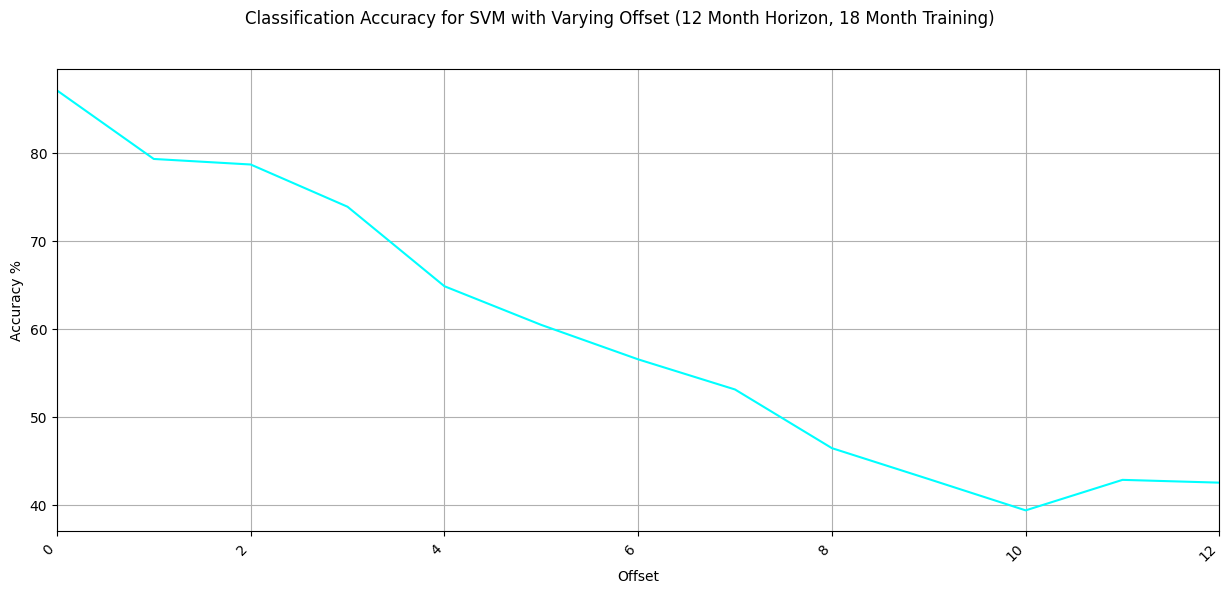

In [ ]:
graphing = pd.DataFrame(columns=['offset', 'accuracy'])
horizon = 12
train = 18
model = svm.LinearSVC()
param_grid = [{'linearsvc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
filename = 'Data_EuroDollar_Avg.csv'
dataset = make_set(horizon, 1, filename)
print(dataset)
scores = []
windows = forcasting(dataset, 0)
for offset in range(horizon+1):
    try:
      lags = int(windows[0])
      estimator = get_estimator(dataset, lags, train, offset, model, param_grid)
      score, _, _, _ = test(dataset, train, lags, estimator, offset)
      graphing.loc[len(graphing)] = [offset, score]
    except Exception as e:
      print(e)
      pass

fig, ax = plt.subplots(figsize=(15,6))
fig.suptitle('Classification Accuracy for SVM with Varying Offset (12 Month Horizon, 18 Month Training)')
print(graphing)

ax.plot(graphing['offset'], graphing['accuracy']+1, color='cyan')

plt.setp(ax.get_xticklabels(), rotation=45,ha='right')
ax.set_ylabel('Accuracy %')
ax.set_xlabel('Offset')
ax.grid()
plt.margins(x=0)

In [ ]:
# prints a file in latex table format
directory = os.listdir('/content/drive/MyDrive')
result = [x for x in directory if 'offset' in x]
for filename in result:
    print(filename)
    graphing = pd.read_csv('/content/drive/MyDrive/'+filename)
    #print(graphing)
    for i in range(0, len(graphing), 3):
      forecasting = graphing.iloc[i]['forcasting']
      row1 = list([float(x) for x in graphing.iloc[i]['accuracy'].replace('[', '').replace(']', '').replace(' ', '').split(',')])
      if len(row1) != 2:
        row1.append(0)
      row2 = list([float(x) for x in graphing.iloc[i+1]['accuracy'].replace('[', '').replace(']', '').replace(' ', '').split(',')])
      if len(row2) != 2:
        row2.append(0)
      row3 = list([float(x) for x in graphing.iloc[i+2]['accuracy'].replace('[', '').replace(']', '').replace(' ', '').split(',')])
      if len(row3) != 2:
        row3.append(0)
      print(str(forecasting)+" & \\makecell{"+"{:.2f}".format(row1[0])+" \\\\ "+"{:.2f}".format(row1[1])+"} & \\makecell{"+"{:.2f}".format(row2[0])+" \\\\ "+"{:.2f}".format(row2[1])+"} & \\makecell{"+"{:.2f}".format(row3[0])+" \\\\ "+"{:.2f}".format(row3[1])+"} \\\\")
      print("\hline")
    input()

Lin1EuroDollaroffset.csv
1 & \makecell{59.39 \\ 62.20} & \makecell{57.58 \\ 54.88} & \makecell{58.18 \\ 52.44} \\
\hline
3 & \makecell{77.30 \\ 53.12} & \makecell{76.07 \\ 50.62} & \makecell{76.69 \\ 56.88} \\
\hline
6 & \makecell{88.39 \\ 44.97} & \makecell{87.10 \\ 44.30} & \makecell{83.87 \\ 40.27} \\
\hline
12 & \makecell{89.33 \\ 45.65} & \makecell{87.33 \\ 47.83} & \makecell{85.33 \\ 47.10} \\
\hline
24 & \makecell{89.86 \\ 30.70} & \makecell{86.96 \\ 44.74} & \makecell{88.41 \\ 43.86} \\
\hline
36 & \makecell{86.15 \\ 35.11} & \makecell{82.31 \\ 40.43} & \makecell{83.08 \\ 50.00} \\
\hline

Log1EuroDollaroffset.csv
1 & \makecell{61.25 \\ 61.64} & \makecell{62.50 \\ 55.35} & \makecell{59.38 \\ 55.35} \\
\hline
3 & \makecell{79.75 \\ 52.90} & \makecell{79.11 \\ 54.84} & \makecell{77.22 \\ 55.48} \\
\hline
6 & \makecell{88.46 \\ 44.67} & \makecell{87.18 \\ 45.33} & \makecell{83.97 \\ 41.33} \\
\hline
12 & \makecell{88.96 \\ 34.51} & \makecell{88.96 \\ 36.62} & \makecell{87.01 \\ 42

1 1Y Li
2 2- Li
2 2- Li
3 3- Li
3 3- Li
1 1Y Lo
2 2- Lo
2 2- Lo
3 3- Lo
3 3- Lo


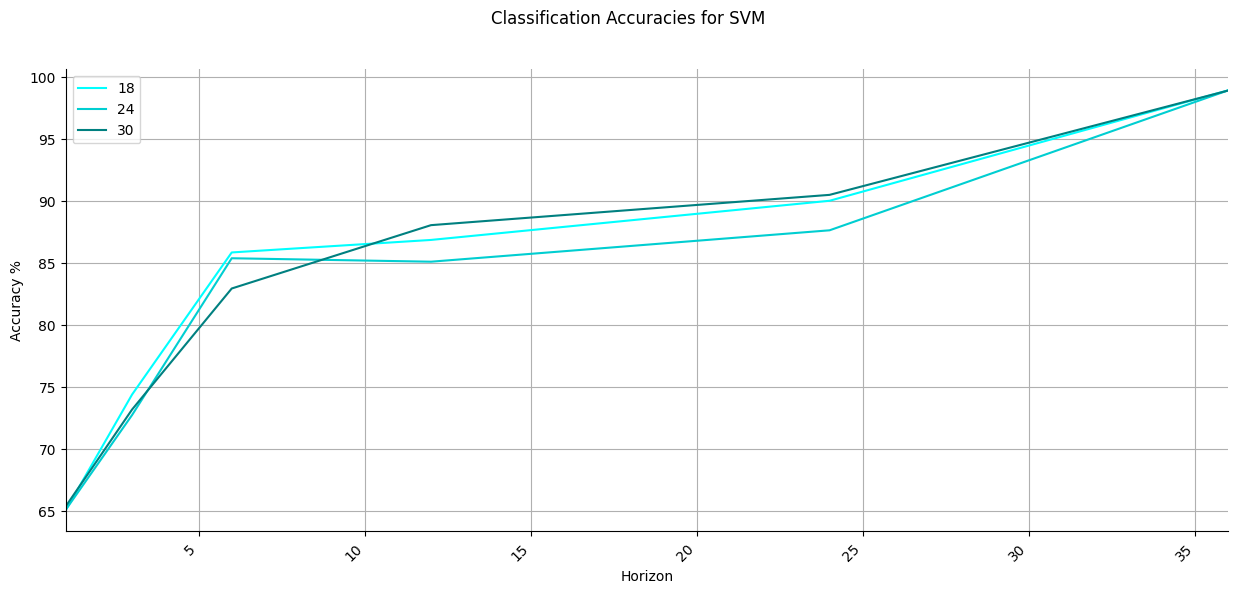

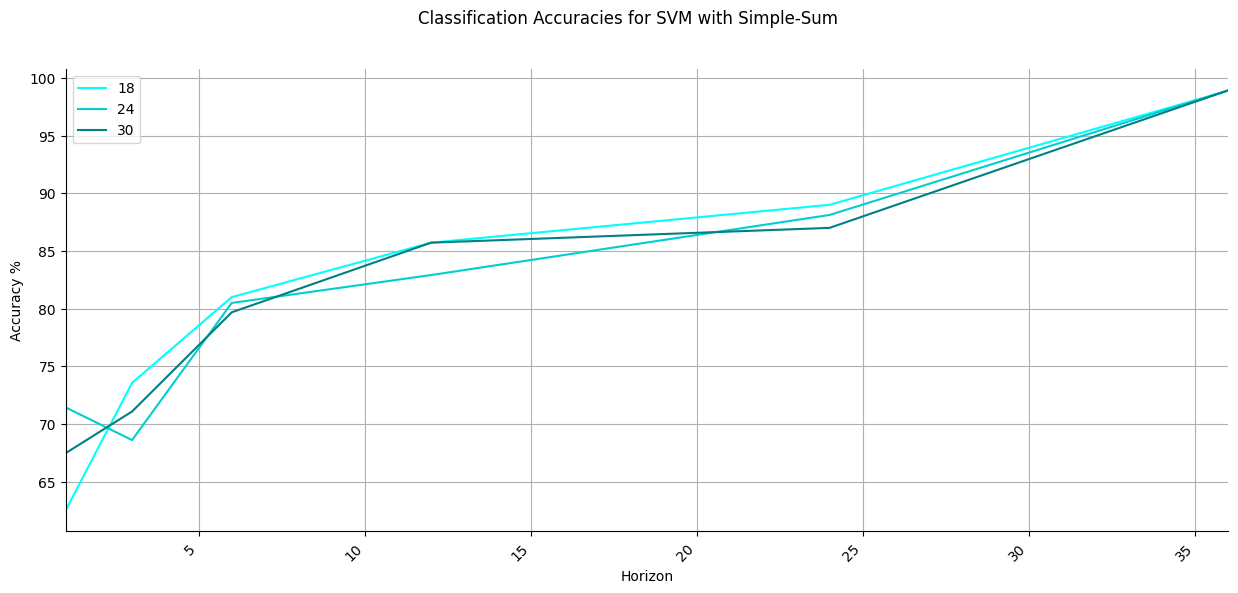

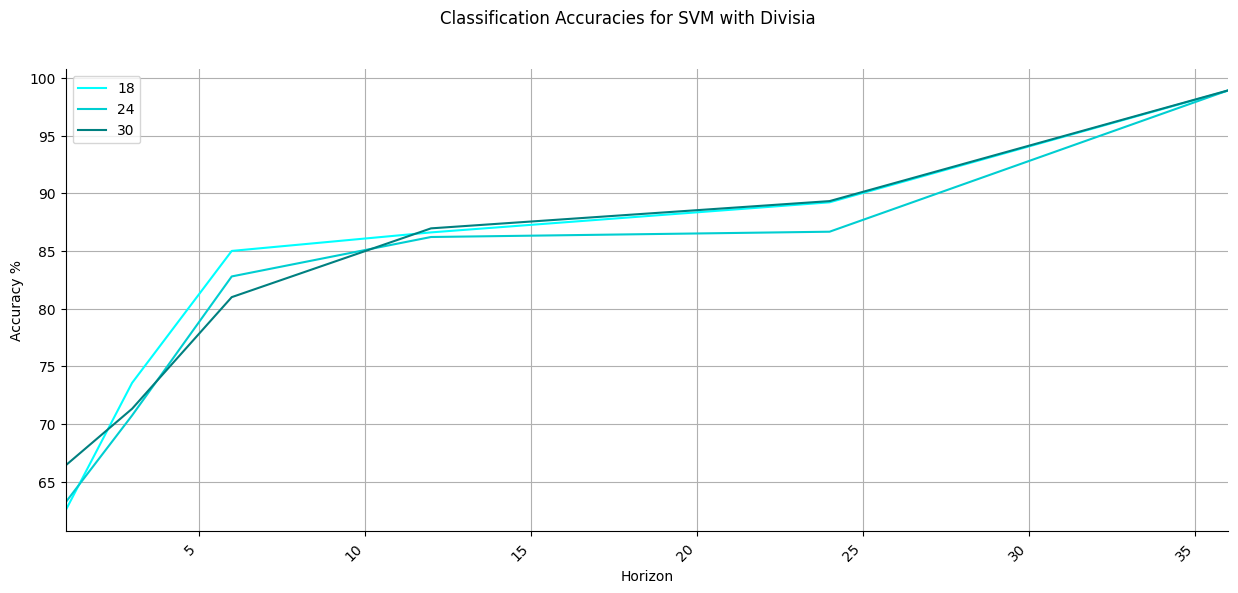

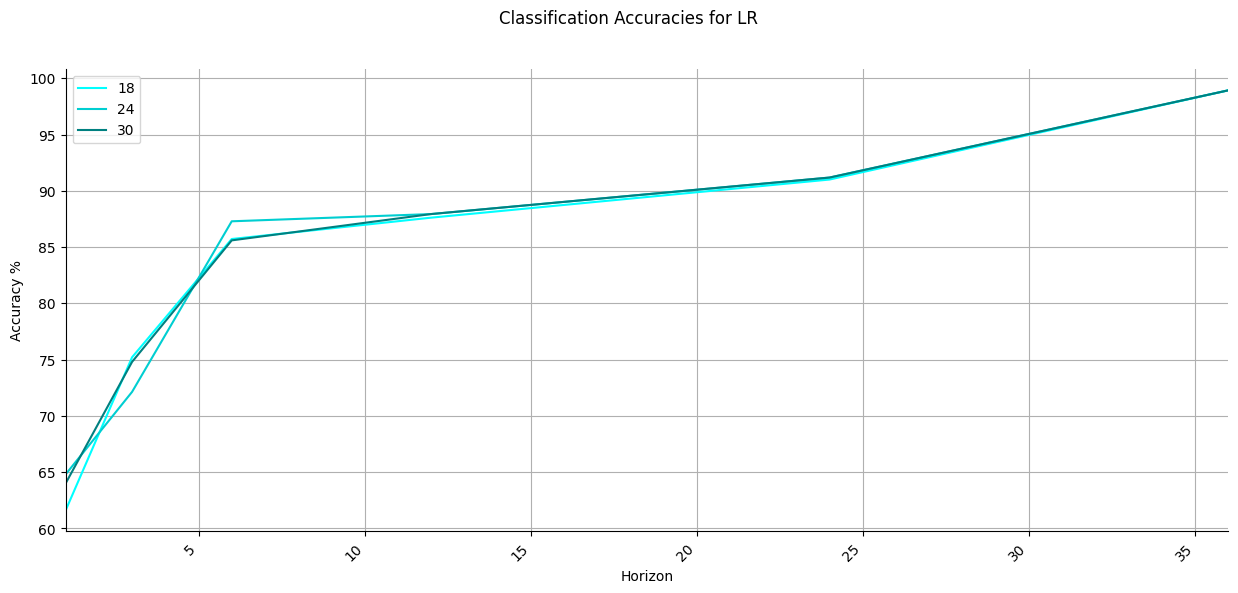

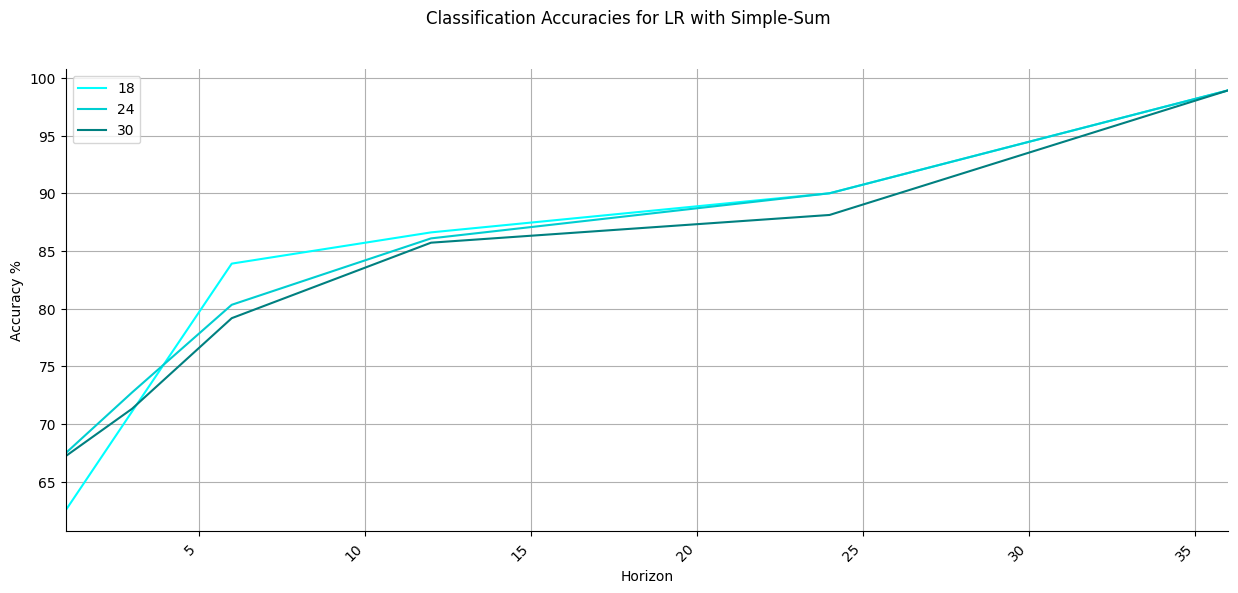

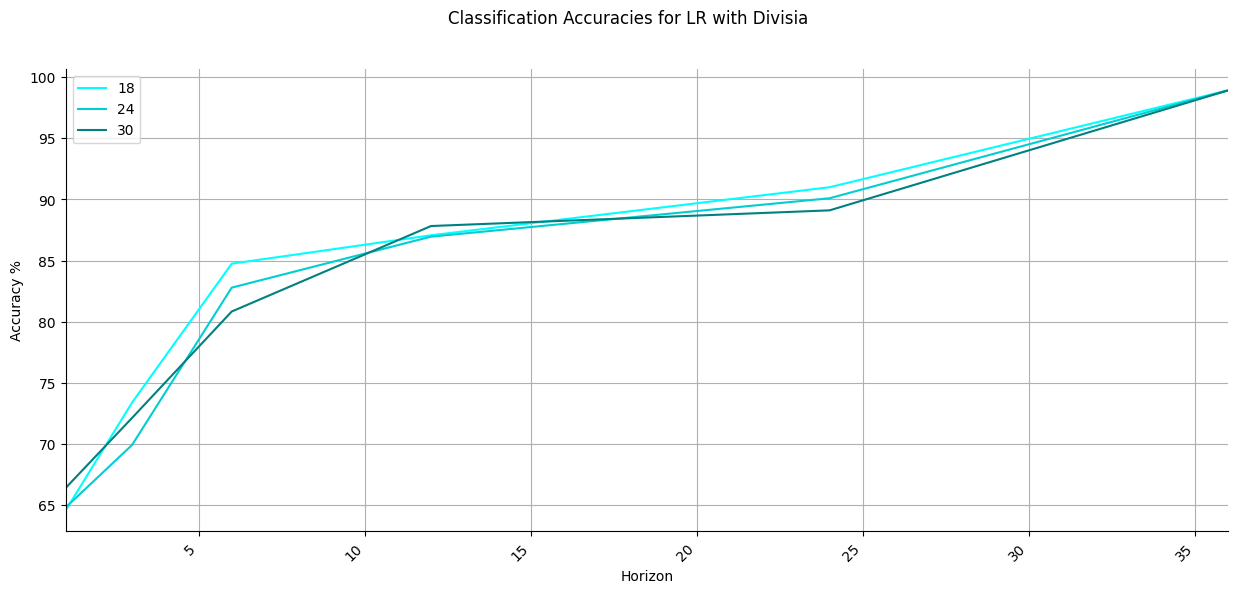

In [ ]:
EX = 'YuanEuro'
EXS = 'YE'
directory = os.listdir('/content/drive/MyDrive')
files = [s for s in directory if EX in s]
result = [x for x in files if x.endswith('csv')]
for filename in result:
    if 'offset' in filename:
      continue
    if 'Dum' in filename:
      continue
    graphing = pd.read_csv('/content/drive/MyDrive/'+filename)
    print(filename[3], filename[3:5], filename[0:2])
    if filename[3] == '1':
        fig, ax = plt.subplots(figsize=(15,6))
        if filename[0:3] == 'Lin':
            fig.suptitle('Classification Accuracies for SVM')
        else:
            fig.suptitle('Classification Accuracies for LR')

        ax.plot(graphing.where(graphing['training'] == 18)['forcasting'].dropna(), graphing.where(graphing['training'] == 18)['accuracy'].dropna(),color='cyan', label='18')
        ax.plot(graphing.where(graphing['training'] == 24)['forcasting'].dropna(), graphing.where(graphing['training'] == 24)['accuracy'].dropna(),color='darkturquoise', label='24')
        ax.plot(graphing.where(graphing['training'] == 30)['forcasting'].dropna(), graphing.where(graphing['training'] == 30)['accuracy'].dropna(),color='teal', label='30')

        plt.setp(ax.get_xticklabels(), rotation=45,ha='right')
        ax.set_ylabel('Accuracy %')
        ax.set_xlabel('Horizon')
        ax.grid()
        ax.legend()
        plt.margins(x=0)
        sns.despine()
        if filename[0:3] == 'Lin':
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_SVM_1_accuracies.png')
        else:
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_LR_1_accuracies.png')

    if filename[3:6] == '3-1':
        fig, ax = plt.subplots(figsize=(15,6))
        if filename[0:3] == 'Lin':
            fig.suptitle('Classification Accuracies for SVM with Simple-Sum')
        else:
            fig.suptitle('Classification Accuracies for LR with Simple-Sum')

        ax.plot(graphing.where(graphing['training'] == 18)['forcasting'].dropna(), graphing.where(graphing['training'] == 18)['accuracy'].dropna(),color='cyan', label='18')
        ax.plot(graphing.where(graphing['training'] == 24)['forcasting'].dropna(), graphing.where(graphing['training'] == 24)['accuracy'].dropna(),color='darkturquoise', label='24')
        ax.plot(graphing.where(graphing['training'] == 30)['forcasting'].dropna(), graphing.where(graphing['training'] == 30)['accuracy'].dropna(),color='teal', label='30')

        plt.setp(ax.get_xticklabels(), rotation=45,ha='right')
        ax.set_ylabel('Accuracy %')
        ax.set_xlabel('Horizon')
        ax.grid()
        ax.legend()
        plt.margins(x=0)
        sns.despine()
        if filename[0:3] == 'Lin':
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_SVM_31_accuracies.png')
        else:
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_LR_31_accuracies.png')


    if filename[3:6] == '3-2':
        fig, ax = plt.subplots(figsize=(15,6))
        if filename[0:3] == 'Lin':
            fig.suptitle('Classification Accuracies for SVM with Divisia')
        else:
            fig.suptitle('Classification Accuracies for LR with Divisia')

        ax.plot(graphing.where(graphing['training'] == 18)['forcasting'].dropna(), graphing.where(graphing['training'] == 18)['accuracy'].dropna(),color='cyan', label='18')
        ax.plot(graphing.where(graphing['training'] == 24)['forcasting'].dropna(), graphing.where(graphing['training'] == 24)['accuracy'].dropna(),color='darkturquoise', label='24')
        ax.plot(graphing.where(graphing['training'] == 30)['forcasting'].dropna(), graphing.where(graphing['training'] == 30)['accuracy'].dropna(),color='teal', label='30')

        plt.setp(ax.get_xticklabels(), rotation=45,ha='right')
        ax.set_ylabel('Accuracy %')
        ax.set_xlabel('Horizon')
        ax.grid()
        ax.legend()
        plt.margins(x=0)
        sns.despine()
        if filename[0:3] == 'Lin':
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_SVM_32_accuracies.png')
        else:
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_LR_32_accuracies.png')

              precision    recall  f1-score   support

        -1.0       0.84      0.83      0.83      1495
         1.0       0.78      0.80      0.79      1183

    accuracy                           0.81      2678
   macro avg       0.81      0.81      0.81      2678
weighted avg       0.81      0.81      0.81      2678



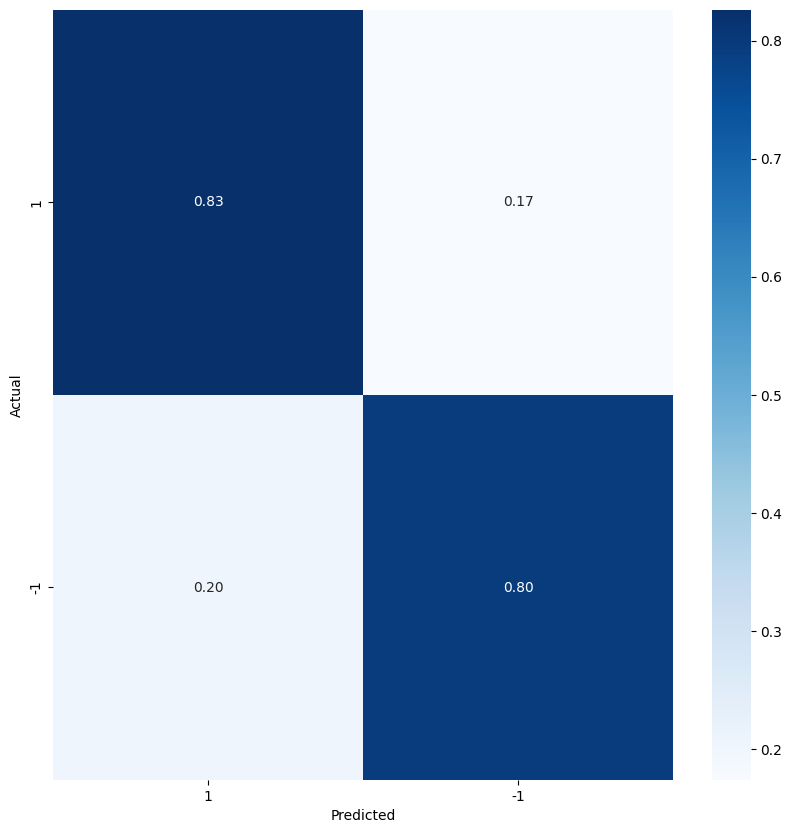

In [ ]:
with open('/content/drive/MyDrive/Lin3-2EuroDollar.txt', 'r') as f:
    data1 = f.read()
data1 = data1.split('%')
y_test1 = data1[0].replace(' ', '')[1:-1].split(',')
y_pred1 = data1[1].replace(' ', '')[1:-1].split(',')

print(classification_report(y_test1, y_pred1))
cm = confusion_matrix(y_test1, y_pred1)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
color = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cmn, cmap=color, annot=True, fmt='.2f', xticklabels=[1, -1], yticklabels=[1, -1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

1 1Y Li
960
960
*** [10.090656875352954]
*** [10.090656875352954, 17.937435753414444]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477, 5.4409280045158095]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477, 5.4409280045158095, 11.633405228048746]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477, 5.4409280045158095, 11.633405228048746, 4.23447945767133]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477, 5.4409280045158095, 11.633405228048746, 4.23447945767133, 6.790713690781327]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477, 5.4409280045158095, 11.633405228048746, 4.23447945767133, 6.790713690781327, 7.215658024268836]
*** [10.090656875352954, 17.937435753414444, 6.56269811097477, 5.4409280045158095, 11.633405228048746, 4.23447945767133, 6.790713690781327, 7.215658024268836, 4.993082249159427]
2 2- Li
2 2- Li
3 3- Li
726
726
*** [20.47626247348376]
*** [20.476

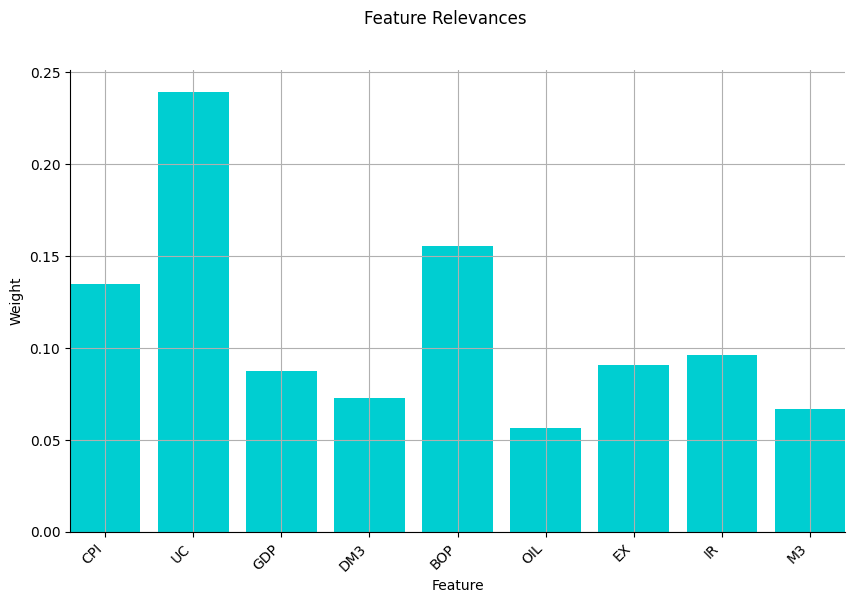

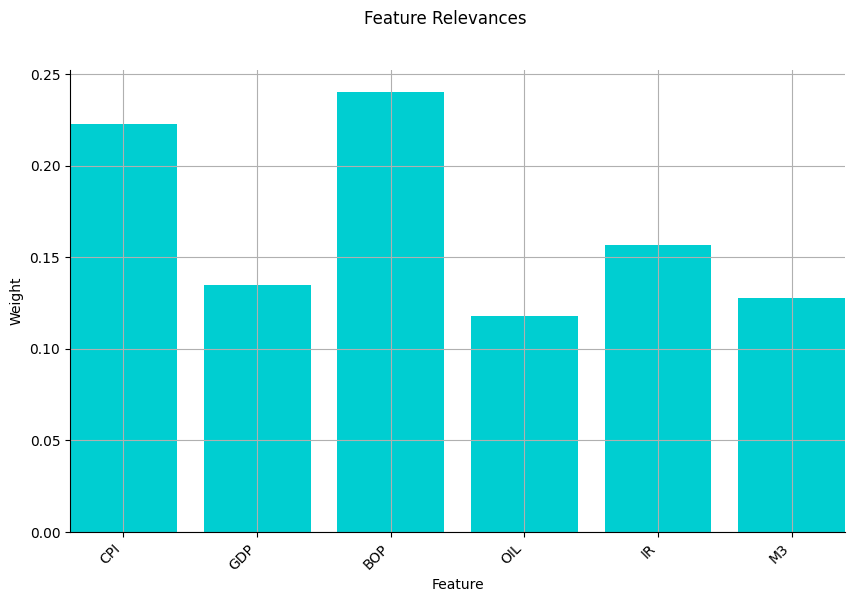

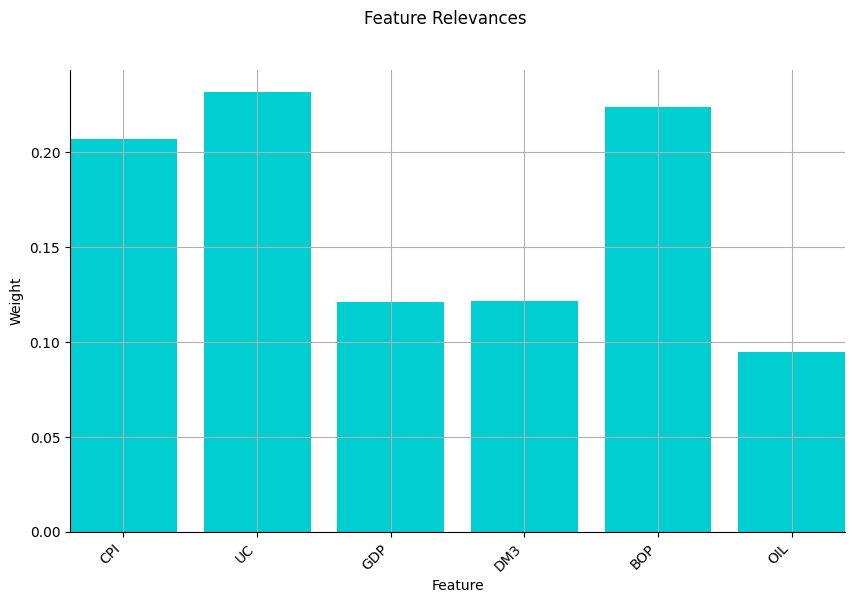

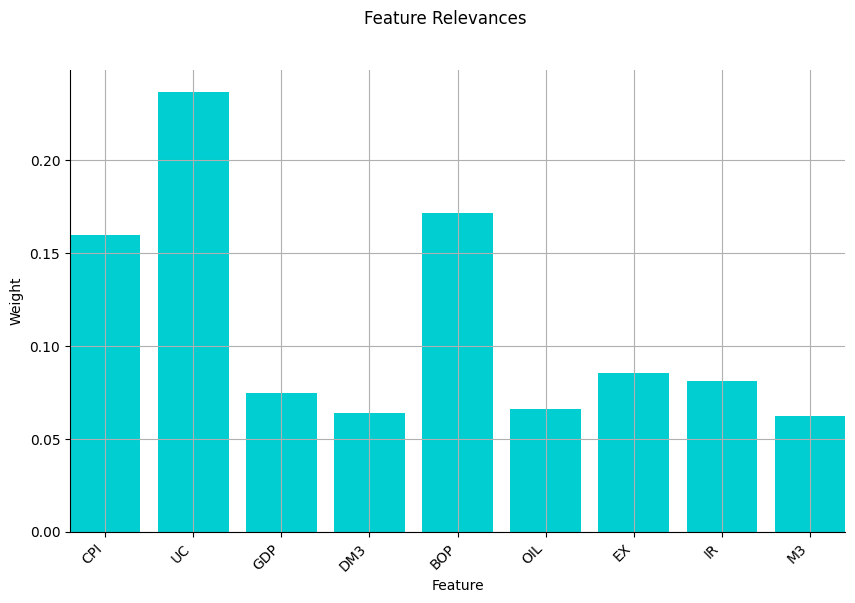

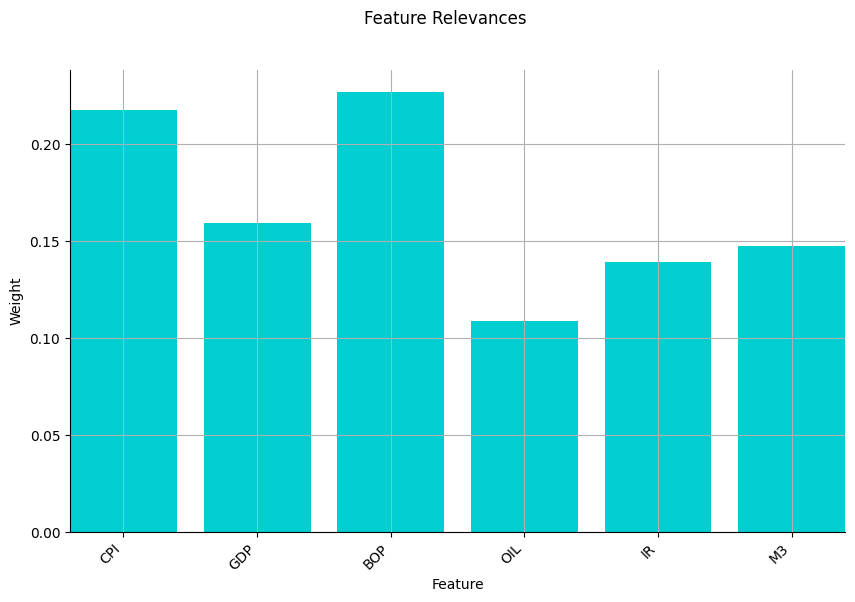

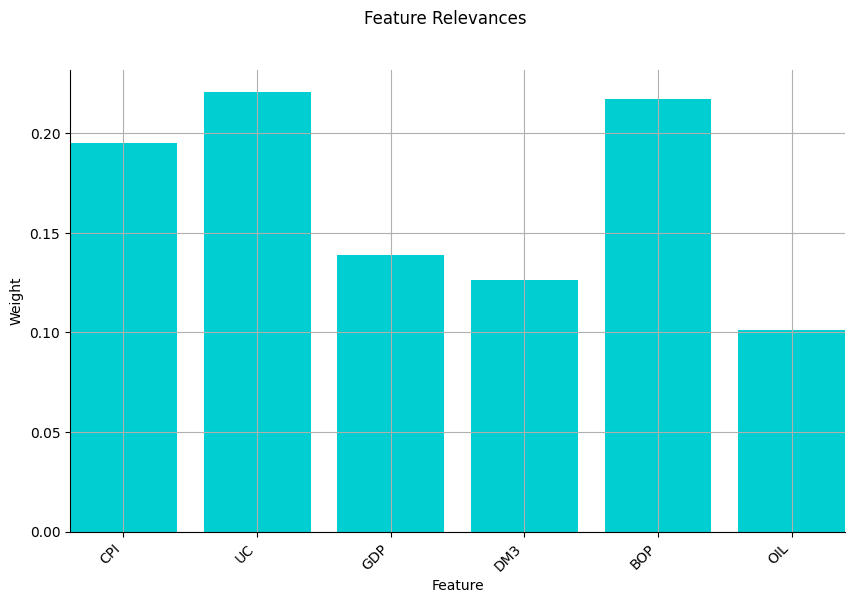

In [ ]:
# outputs feature importance plots
EX = 'YuanEuro'  # exchnage rate
EXS = 'YE'  # abriation
directory = os.listdir('/content/drive/MyDrive')
files = [s for s in directory if EX in s]
result = [x for x in files if x.endswith('txt')]
for filename in result:
    if 'offset' in filename:
      continue
    if 'Dum' in filename:
      continue
    with open('/content/drive/MyDrive/'+filename, 'r') as f:
        data = f.read()
    print(filename[3], filename[3:5], filename[0:2])
    if filename[3] == '1':
        data = data.split('%')
        importances = data[2].replace(' ', '')[1:-1].split(',')
        importances = [int(x) for x in importances]
        feature_names = data[3].replace(' ', '')[1:-1].split(',')
        ws = data[4].replace(' ', '')[1:-1].split(',')
        ws = [l.split(',') for l in ','.join(ws).split('###')]
        ws = [[float(x) for x in sublist if x != "'"] for sublist in ws]
        print(len(importances))
        print(len(feature_names))
        length = 0
        for i in ws:
          length += len(i)
        features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL', 'EX', 'IR', '_M3']  # experiment 1
        #features = ['CPI', 'GDP', 'BOP', 'OIL', 'IR', 'M3']  # experient 3.1
        #features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL']  # experient 3.2
        culms = []
        for name in features:
          temp = []
          s = 0
          for w in ws:
            f = len(w)
            importance_list = importances[s:s+f]
            initial_feature_names = feature_names[s:s+f]

            arr = np.array([w[j] for j in importance_list])
            temp_features = [initial_feature_names[j] for j in importance_list]
            for i in range(len(temp_features)):
                if name in temp_features[i]:
                    temp.append(arr[i])
            s = s+f
          culms.append(sum(temp))
          print("***", culms)

        features = [item.replace("_", "") for item in features]
        norm = [float(i)/sum(culms) for i in culms]
        fig, ax = plt.subplots(figsize=(10,6))
        fig.suptitle('Feature Relevances')
        ax.bar(features,norm,color='darkturquoise')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylabel('Weight')
        ax.set_xlabel('Feature')
        plt.grid()
        plt.margins(x=0)
        sns.despine()
        if filename[0:3] == 'Lin':
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_SVM_1_weights.png')
        else:
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_LR_1_weights.png')

    if filename[3:6] == '3-1':
        data = data.split('%')
        importances = data[2].replace(' ', '')[1:-1].split(',')
        importances = [int(x) for x in importances]
        feature_names = data[3].replace(' ', '')[1:-1].split(',')
        ws = data[4].replace(' ', '')[1:-1].split(',')
        ws = [l.split(',') for l in ','.join(ws).split('###')]
        ws = [[float(x) for x in sublist if x != "'"] for sublist in ws]
        print(len(importances))
        print(len(feature_names))
        length = 0
        for i in ws:
          length += len(i)
        #features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL', 'EX', 'IR', '_M3']
        features = ['CPI', 'GDP', 'BOP', 'OIL', 'IR', 'M3']
        #features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL']
        culms = []
        for name in features:
          temp = []
          s = 0
          for w in ws:
            f = len(w)
            importance_list = importances[s:s+f]
            initial_feature_names = feature_names[s:s+f]

            arr = np.array([w[j] for j in importance_list])
            temp_features = [initial_feature_names[j] for j in importance_list]
            for i in range(len(temp_features)):
                if name in temp_features[i]:
                    temp.append(arr[i])
            s = s+f
          culms.append(sum(temp))
          print("***", culms)

        features = [item.replace("_", "") for item in features]
        norm = [float(i)/sum(culms) for i in culms]
        fig, ax = plt.subplots(figsize=(10,6))
        fig.suptitle('Feature Relevances')
        ax.bar(features,norm,color='darkturquoise')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylabel('Weight')
        ax.set_xlabel('Feature')
        plt.grid()
        plt.margins(x=0)
        sns.despine()
        if filename[0:3] == 'Lin':
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_SVM_31_weights.png')
        else:
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_LR_31_weights.png')


    if filename[3:6] == '3-2':
        data = data.split('%')
        importances = data[2].replace(' ', '')[1:-1].split(',')
        importances = [int(x) for x in importances]
        feature_names = data[3].replace(' ', '')[1:-1].split(',')
        print(ws)
        ws = data[4].replace(' ', '')[1:-1].split(',')
        ws = [l.split(',') for l in ','.join(ws).split('###')]
        print(ws)
        ws = [[float(x) for x in sublist if x != "'"] for sublist in ws]
        print(len(importances))
        print(len(feature_names))
        length = 0
        for i in ws:
          length += len(i)
        #features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL', 'EX', 'IR', '_M3']
        #features = ['CPI', 'GDP', 'BOP', 'OIL', 'IR', 'M3']
        features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL']
        culms = []
        for name in features:
          temp = []
          s = 0
          for w in ws:
            f = len(w)
            importance_list = importances[s:s+f]
            initial_feature_names = feature_names[s:s+f]

            arr = np.array([w[j] for j in importance_list])
            temp_features = [initial_feature_names[j] for j in importance_list]
            for i in range(len(temp_features)):
                if name in temp_features[i]:
                    temp.append(arr[i])
            s = s+f
          culms.append(sum(temp))
          print("***", culms)

        features = [item.replace("_", "") for item in features]
        norm = [float(i)/sum(culms) for i in culms]
        fig, ax = plt.subplots(figsize=(10,6))
        fig.suptitle('Feature Relevances')
        ax.bar(features,norm,color='darkturquoise')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylabel('Weight')
        ax.set_xlabel('Feature')
        plt.grid()
        plt.margins(x=0)
        sns.despine()
        if filename[0:3] == 'Lin':
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_SVM_32_weights.png')
        else:
            plt.savefig('/content/drive/MyDrive/figures/'+EXS+'_LR_32_weights.png')

In [ ]:
window = 6
train = 18
horizon = 12
offset = 0
dataset = make_set(horizon, 1, 'Data_YuanEuro.csv')
start_date = dt.date(2002,1,1)
# grids = [{'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] [{'linearsvc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
#estimator = get_estimator(dataset, window, train, 0, svm.LinearSVC(), [{'linearsvc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}])
estimator = get_estimator(dataset, window, train, 0, linear_model.LogisticRegression(), [{'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}])
best_estimator = estimator
X = createRollingWindow(dataset,window).drop('Direction', axis=1)
y = createRollingWindow(dataset,window)['Direction']
initial_feature_names = list(createRollingWindow(dataset,window).iloc[:,:-2].columns)
rankings = pd.DataFrame(columns=initial_feature_names)
print(initial_feature_names)
features = ['CPI', 'UC', 'GDP', 'DM3', 'BOP', 'OIL', 'EX', 'IR', '_M3']

scores = []
predicted = []
target = []
n = 0
_, s = createRollingWindow(dataset,window).iloc[:,2:].shape
w = np.zeros(shape=(s,))
eng_set = createRollingWindow(dataset, window)

for trains, tests in split_time_series(eng_set.drop(['Direction'], axis=1), train_period=train, offset=offset):
        traind = eng_set.loc[trains]
        majority_val = int(traind.Direction.mode()[0])
        majority = traind[traind['Direction'] == majority_val]
        minority = traind[traind['Direction'] != majority_val]
        # Downsample majority class
        df_majority_downsampled = resample(majority, replace=False, n_samples=len(minority))
        downsample = pd.concat([df_majority_downsampled, minority])
        X_train = downsample.drop(['Direction', 'Date'], axis=1)
        y_train = downsample['Direction']
        X_test = eng_set.loc[tests].drop(['Direction', 'Date'], axis=1)
        y_test = eng_set.loc[tests]['Direction']

        ranking = [0]*(len(initial_feature_names)+1)
        selector = RFE(best_estimator[1], n_features_to_select=1)
        pipeline = make_pipeline(scaler, selector, best_estimator[1])
        print(pipeline)

        try:
            pipeline.fit(X_train, y_train)
            ranking = list(pipeline.named_steps['rfe'].ranking_)
            rankings.loc[len(rankings)] = ranking
        except ValueError:
            pass

print(rankings)
means = rankings.mean(axis=0)
print(means)
means1 = []
i = 0
for name in features:
  total = 0
  total1 = 0
  for name1, value in means.items():
    if name in name1:
      total1 += 1
      total += value
  means1.append(total/total1)
print(features)
print(means1)
print("output", [x for _, x in sorted(zip(means1, features))])



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
171 fits failed out of a total of 1377.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
171 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
ValueError: This solver needs samples of a

['EXEUCH', 'HN_GDP', 'HN_IR', 'HN_CPI', 'HN_M3', 'HN_BOP', 'HN_DM3', 'HN_UC', 'EU_GDP', 'EU_IR', 'EU_CPI', 'EU_M3', 'EU_BOP', 'EU_DM3', 'EU_UC', 'OIL_Avg', 'EXEUCH', 'HN_GDP', 'HN_IR', 'HN_CPI', 'HN_M3', 'HN_BOP', 'HN_DM3', 'HN_UC', 'EU_GDP', 'EU_IR', 'EU_CPI', 'EU_M3', 'EU_BOP', 'EU_DM3', 'EU_UC', 'OIL_Avg', 'EXEUCH', 'HN_GDP', 'HN_IR', 'HN_CPI', 'HN_M3', 'HN_BOP', 'HN_DM3', 'HN_UC', 'EU_GDP', 'EU_IR', 'EU_CPI', 'EU_M3', 'EU_BOP', 'EU_DM3', 'EU_UC', 'OIL_Avg', 'EXEUCH', 'HN_GDP', 'HN_IR', 'HN_CPI', 'HN_M3', 'HN_BOP', 'HN_DM3', 'HN_UC', 'EU_GDP', 'EU_IR', 'EU_CPI', 'EU_M3', 'EU_BOP', 'EU_DM3', 'EU_UC', 'OIL_Avg', 'EXEUCH', 'HN_GDP', 'HN_IR', 'HN_CPI', 'HN_M3', 'HN_BOP', 'HN_DM3', 'HN_UC', 'EU_GDP', 'EU_IR', 'EU_CPI', 'EU_M3', 'EU_BOP', 'EU_DM3', 'EU_UC', 'OIL_Avg', 'EXEUCH', 'HN_GDP', 'HN_IR', 'HN_CPI', 'HN_M3', 'HN_BOP', 'HN_DM3', 'HN_UC', 'EU_GDP', 'EU_IR', 'EU_CPI', 'EU_M3', 'EU_BOP', 'EU_DM3', 'EU_UC', 'OIL_Avg']
Pipeline(steps=[('standardscaler', StandardScaler()),
               

In [ ]:
# wilcoxon test and accuracy comaparison
graphing = pd.read_csv('/content/drive/MyDrive/Lin3-1EuroDollar.csv')
graphing1 = pd.read_csv('/content/drive/MyDrive/Dum1EuroDollar.csv')
list1 = graphing['accuracy']
list2 = graphing1['accuracy']
total = 0
for i in range(len(list1)):
  if list1[i] > list2[i]:
    total += 1
print(total/len(list1))
print(wilcoxon(list1, list2, alternative='greater'))

1.0
WilcoxonResult(statistic=171.0, pvalue=3.814697265625e-06)
